# Funathon 2023 - Sujet 3

Responsables :
- Julie Sixou, D2E
- Antoine Palazzolo, SSP Lab
- Thomas Faria, SSP Lab

# Habitudes alimentaires à partir des données INCA

## Avant de commencer...

Ce sujet est disponible dans 2 langages : R et Python.
Ce notebook correspond à la version R, qui est la plus réduite des deux. En effet, la partie 3 sur les premiers pas en Machine Learning est spécifique à Python.

Il s'agit là principalement d'une initiation à l'analyse de données et à la data visualization, à travers l'étude des données de consommations et habitudes alimentaires de l'[étude INCA 3](https://www.data.gouv.fr/fr/datasets/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/).
Le sujet est constituée de 3 parties distinctes et indépendantes :
- Analyse exploratoire des données et visualisations
- Clustering d'individus : ACP, K-moyennes, Clustering Ascendant Hiérarchique
- __Absente du sujet en R__ : _Prédiction de l'IMC : premiers pas vers les méthodes de ML supervisé_

Il est également possible de ne faire qu'une ou deux parties du sujet. A noter que les corrigés présentés dans le sujet ne sont qu'une suggestion de comment répondre aux questions posées, mais qu'il existe évidemment d'autres manières de faire, parfois même bien meilleures.

Si jamais vous n'êtes pas familiers avec R, nous ne saurions que trop vous recommander de jeter un oeil aux ressources suivantes :
- Débuter avec R : https://www.utilitr.org/
- Bonnes pratiques en R : https://www.pratiques.utilitr.org/

Pour en savoir plus sur les données utilisées pour ce sujet et sur le contexte de l'étude : https://www.data.gouv.fr/fr/datasets/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/

Pour lire la documentation associée aux données : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf

### Imports

Exécutez à présent la cellule ci-dessous pour installer les packages nécessaires au sujet :

In [ ]:
# Lecture du fichier requirements.txt
requirements <- readLines("requirements_R.txt")

# Installation des packages
for (package in requirements) {
  install.packages(package)
}

Exécutez également les cellules ci-dessous pour importer l'ensemble des jeux de données nécessaires à l'étude :

In [ ]:
library(aws.s3)
library(dplyr)
library(readr)

#### Imports des données avec s3

A favoriser, en utilisant les données déjà importées sur le Datalab (si vous y avez bien accès)

In [3]:
bucket <- "projet-funathon"
path_data <- "2023/sujet3/diffusion"

In [4]:
description_indiv <- s3read_using(read_delim, object = paste(path_data, "description-indiv.csv", sep="/"), bucket = bucket, opts = list('region'=''), show_col_types = FALSE)
habitudes_indiv <- s3read_using(read_delim, object = paste(path_data, "habitudes-indiv.csv", sep="/"), bucket = bucket, opts = list('region'=''), show_col_types = FALSE)
actphys_sedent <- s3read_using(read_delim, object = paste(path_data, "actphys-sedent.csv", sep="/"), bucket = bucket, opts = list('region'=''), show_col_types = FALSE)
fpq <- s3read_using(read_delim, object = paste(path_data, "fpq.csv", sep="/"), bucket = bucket, opts = list('region'=''), show_col_types = FALSE)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


#### Imports des données depuis data.gouv.fr

A n'utiliser que si vous n'avez pas accès au système s3 du SSP Cloud :

```r
# Lecture des fichiers CSV
description_indiv <- read_delim("https://www.data.gouv.fr/fr/datasets/r/f982ee4a-b2db-4608-ab95-bfe51dfc4897", delim=";")
habitudes_indiv <- read_delim("https://www.data.gouv.fr/fr/datasets/r/099351b9-e32e-4e38-8f23-dec21fd07c71", delim=";")
actphys_sedent <- read_delim("https://www.data.gouv.fr/fr/datasets/r/e9a34b81-2105-4d82-a023-c14947fb2b2c", delim=";")
fpq <- read_delim("https://www.data.gouv.fr/fr/datasets/r/32e79499-9897-423b-acd6-143121340f86", delim=";")

```

## Partie 1 : Analyse exploratoire des données et visualisations

Premier point de contact : Julie Sixou

Boîte à outils de ce qu'il est possible de faire avec ```dplyr``` et ```ggplot2```

Explorons la base de données INCA3 : dans cette partie, nous allons vous montrer comment produire des graphes et statistiques univariées et bivariées.

Le dictionnaire des variables et des modalités peut se trouver ici : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf
<br>

### Imports

In [5]:
# Import des librairies

library(ggplot2)
library(ggcorrplot)
library(sf)

Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE



In [6]:
# Option d'affichage
options(dplyr.width = Inf)
options(repr.plot.width=20, repr.plot.height=10)

### 1. Statistiques univariées avec la table _description_indiv_

Quelques exemples de ce qu'il est possible de faire avec ```ggplot2``` :

Warning message:
“Removed 14 rows containing non-finite values (`stat_bin()`).”


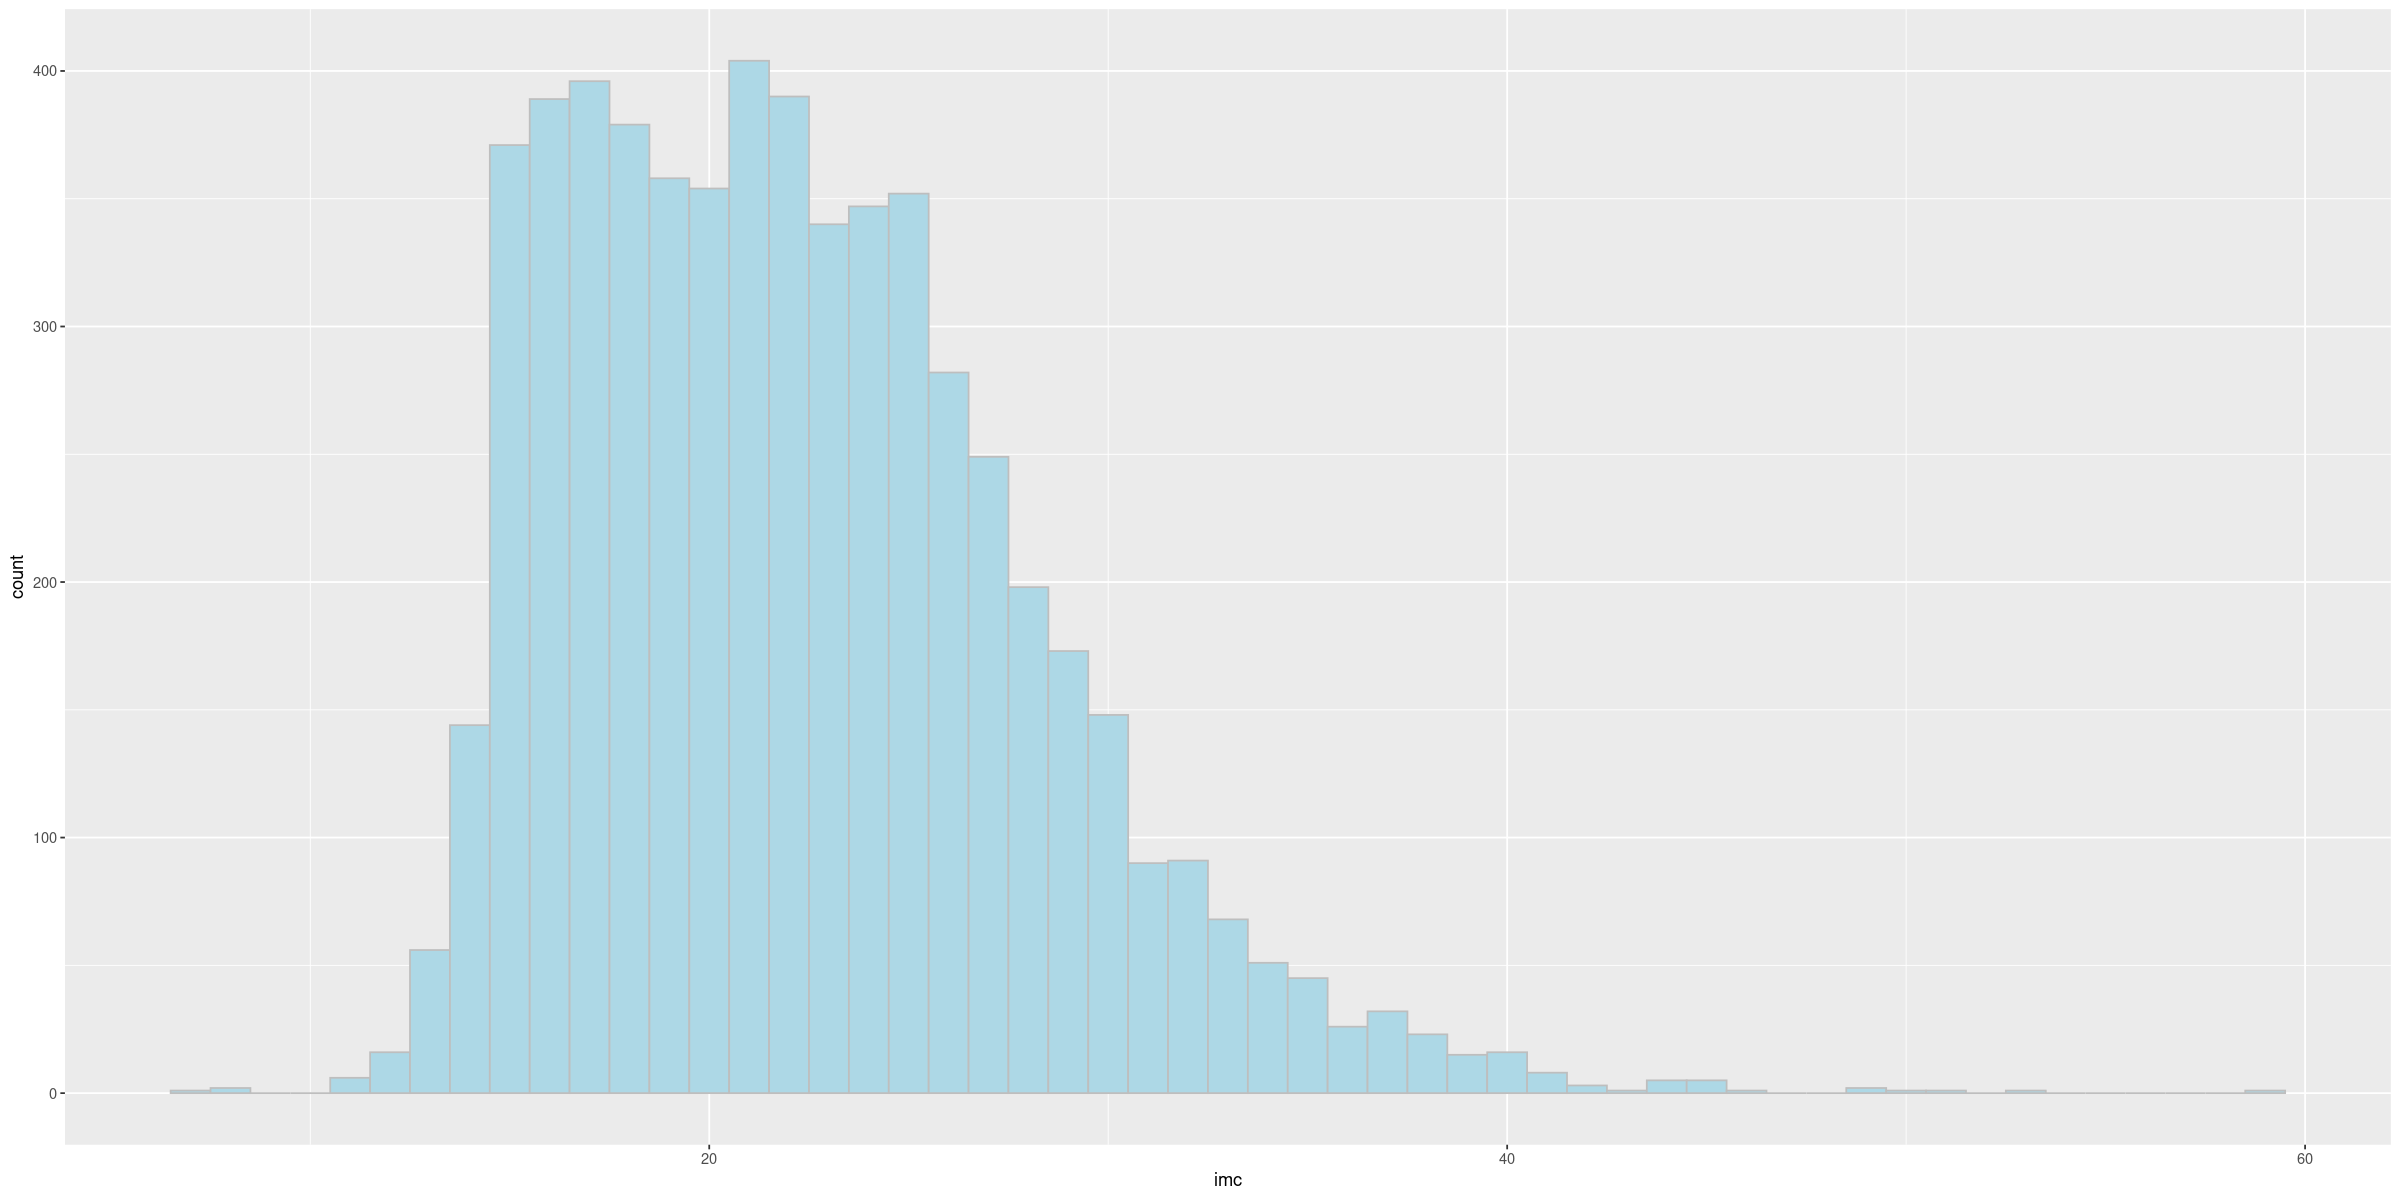

In [7]:
# Histogramme des IMC

ggplot(data=description_indiv,aes(x=imc))+
    geom_histogram(binwidth=1,color="grey",fill="lightblue")

Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


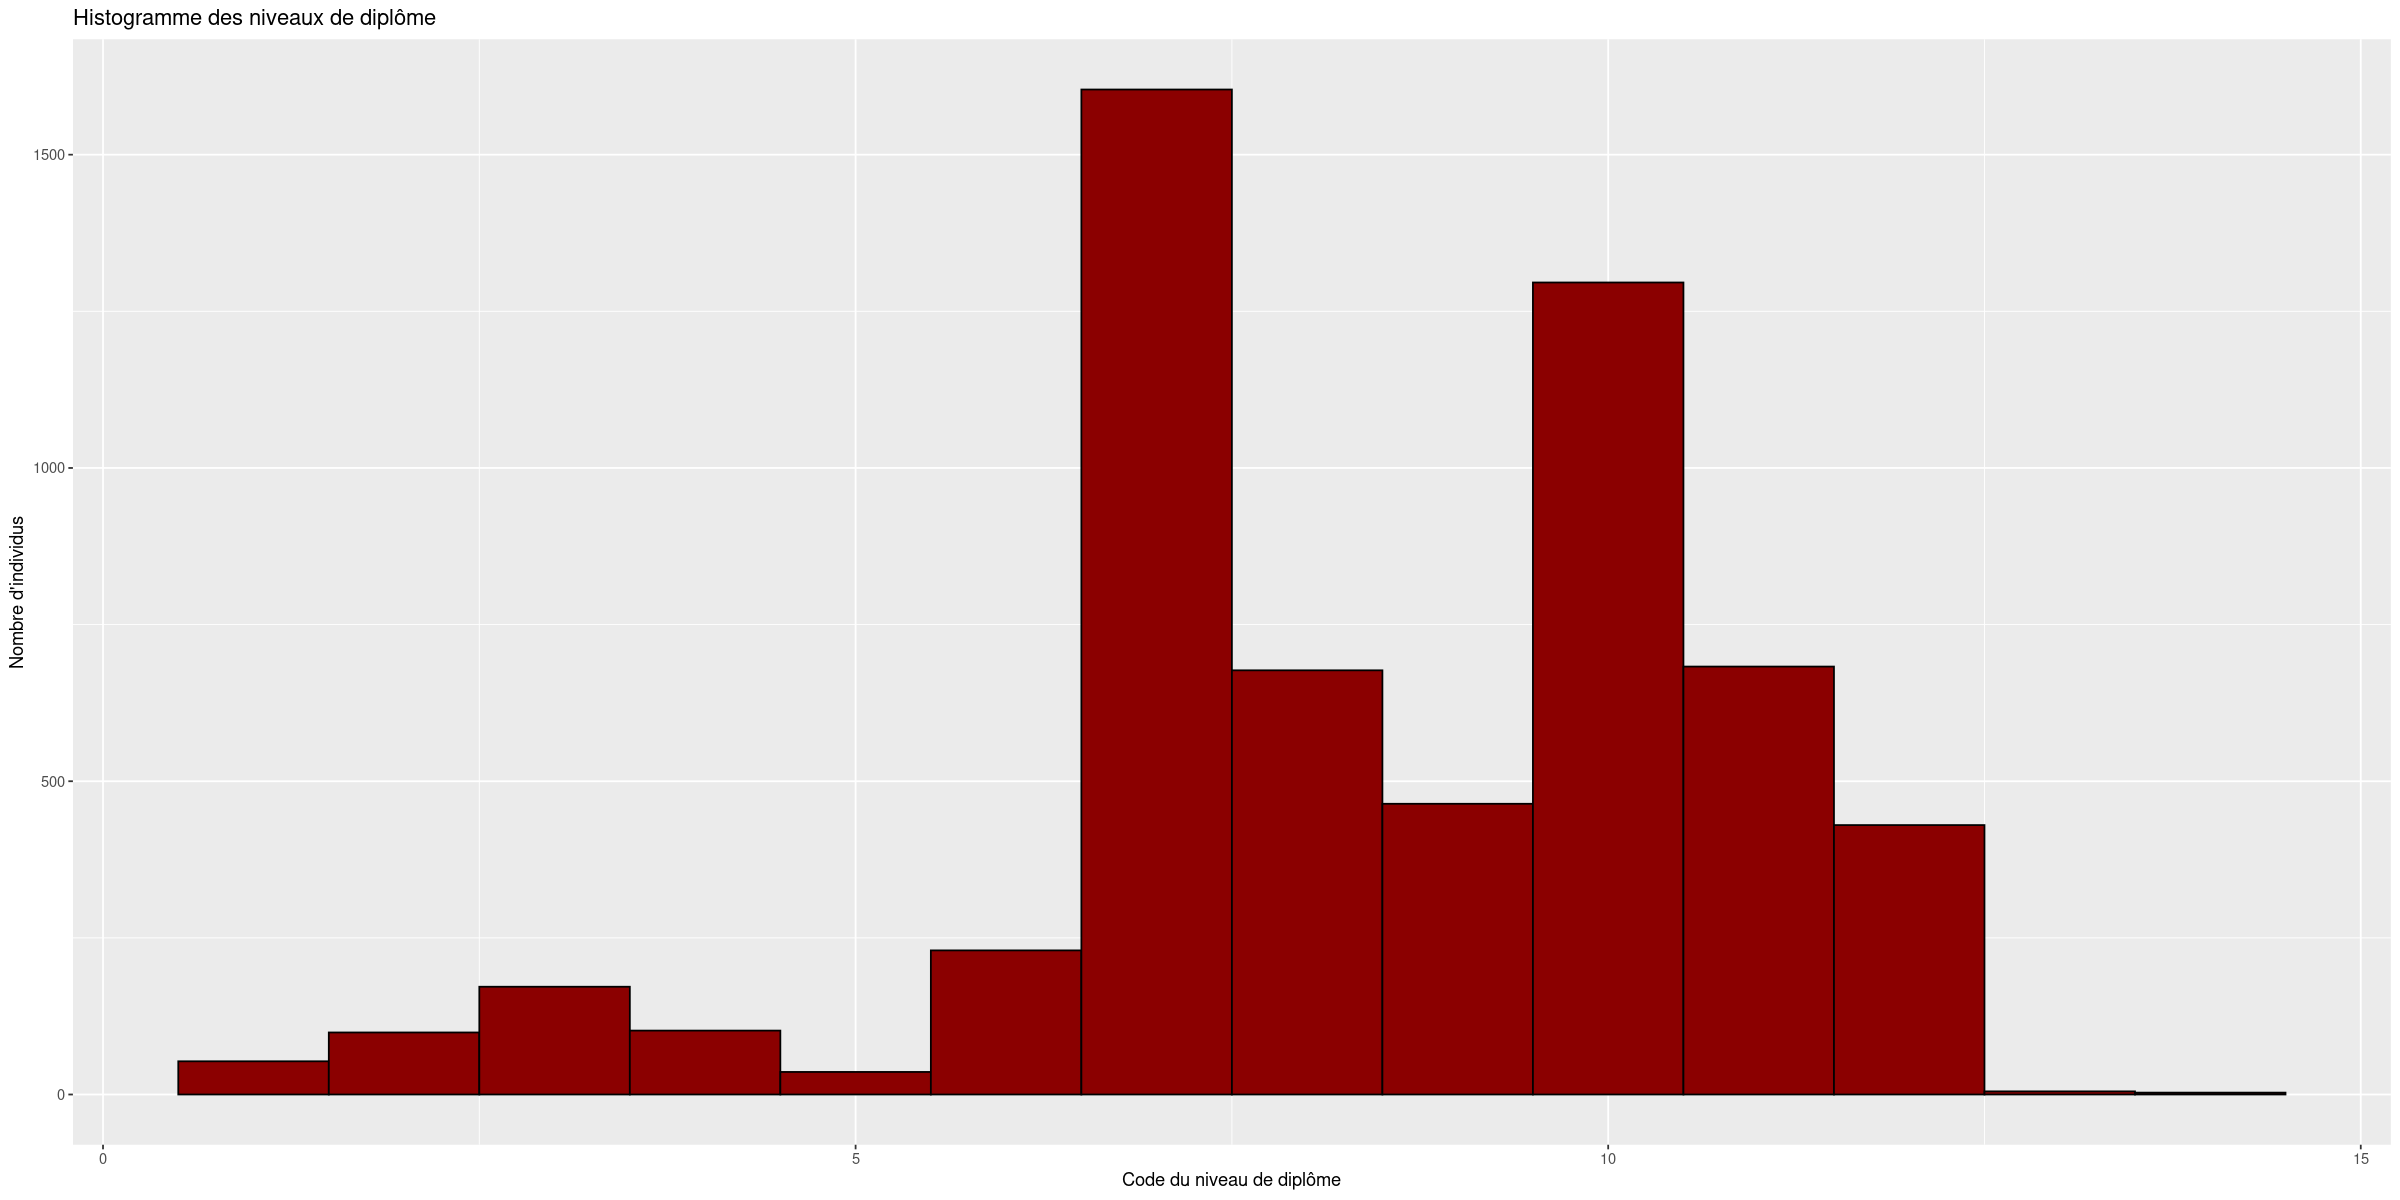

In [8]:
# Histogramme des niveaux de diplôme

ggplot(data=description_indiv,aes(x=diplome_interv))+ 
    geom_histogram(binwidth=1,color="black",fill="darkred")+
    labs(title="Histogramme des niveaux de diplôme",  # cette fois on rajoute des légendes
    x="Code du niveau de diplôme",
    y="Nombre d'individus")

Recodons la variable des niveaux de diplôme pour mieux comprendre le graphe :

In [9]:
# Recodage des niveaux de diplôme

description_indiv <- description_indiv %>% mutate(categorie_diplome=case_when(diplome_interv==1 ~ "Aucun diplôme, n'a jamais été scolarisé",
                                                                              diplome_interv==2 ~ "Aucun diplôme, scolarité s'est arrêtée à l'école primaire",
                                                                              diplome_interv==3 ~ "Aucun diplôme, scolarité s'est arrêtée au collège",
                                                                              diplome_interv==4 ~ "Aucun diplôme, scolarité s'est arrêtée au delà du collège",
                                                                              diplome_interv==5 ~ "Aucun diplôme, sans précision",
                                                                              diplome_interv==6 ~ "CEP",
                                                                              diplome_interv==7 ~ "CAP, BEP, BEPC, brevet élémentaire, brevet de compagnon",
                                                                              diplome_interv==8 ~ "Baccalauréat technologique ou professionnel,\nBrevet professionnel ou de technicien,\nBEA, BEC, BEI, BEH, capacité en droit",
                                                                              diplome_interv==9 ~ "Baccalauréat général",
                                                                              diplome_interv==10 ~ "Diplôme de 1er cycle universitaire (Bac +3, licence),\nBTS, DUT, DEST, DEUG, diplôme des professions\nsociales ou de la santé, d'infirmier",
                                                                              diplome_interv==11 ~ "Diplôme de 2ème cycle universitaire (Bac+4, Bac+5),\nMaster, Maîtrise, diplôme d'ingénieur,\nd'une grande école",
                                                                              diplome_interv==12 ~ "Diplôme de 3ème cycle universitaire (>Bac+5, doctorat),\ndiplôme de vétérinaire, médecin, pharmacien",
                                                                              diplome_interv==13 ~ "Refus",
                                                                              diplome_interv==14 ~ "Ne sait pas"))

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


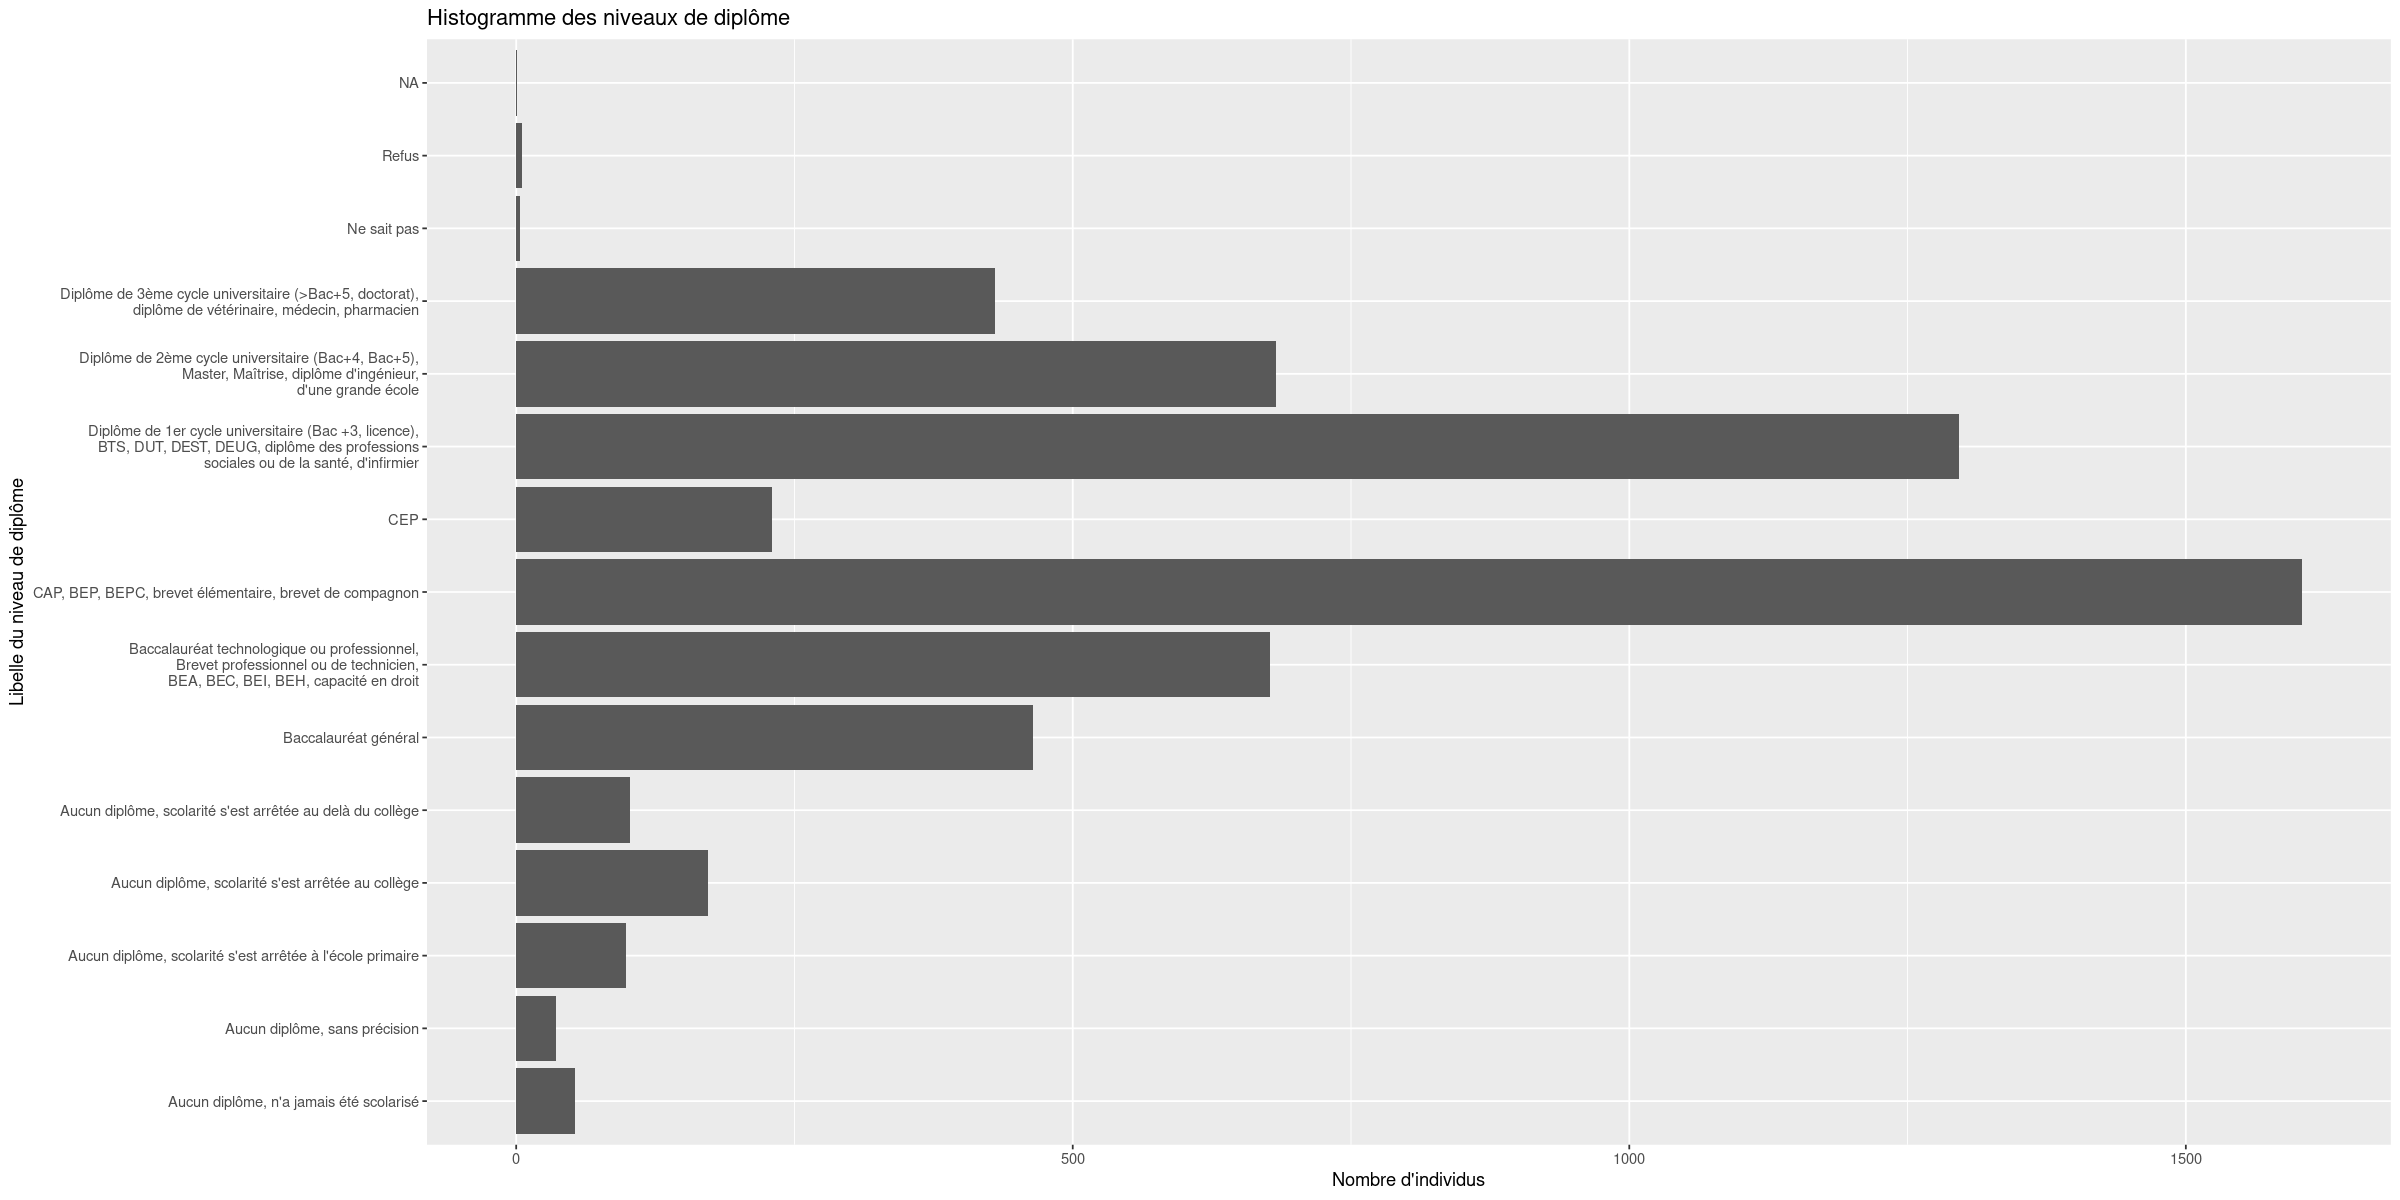

In [10]:
# Tableau des fréquences de chaque catégorie de diplome
counts_diplome <- description_indiv %>% group_by(categorie_diplome) %>% summarise(n=n())

# Graphique en barres horizontales
ggplot(data=counts_diplome,aes(x=categorie_diplome,y=n))+
    geom_histogram(stat="identity")+
coord_flip()+
labs(title="Histogramme des niveaux de diplôme",
     x="Libelle du niveau de diplôme",
     y="Nombre d'individus")

In [11]:
# Recodage de la variable de type d'agglomération

description_indiv <- description_indiv %>% mutate(categorie_agglo = case_when(agglo_5cl==1 ~ "Rural",
                                                                             agglo_5cl==2 ~ "2000 - 19 999 hab",
                                                                             agglo_5cl==3 ~ "20 000 - 99 999 hab",
                                                                             agglo_5cl==4 ~ "+ 100 000 hab",
                                                                             agglo_5cl==5 ~ "Paris"))

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


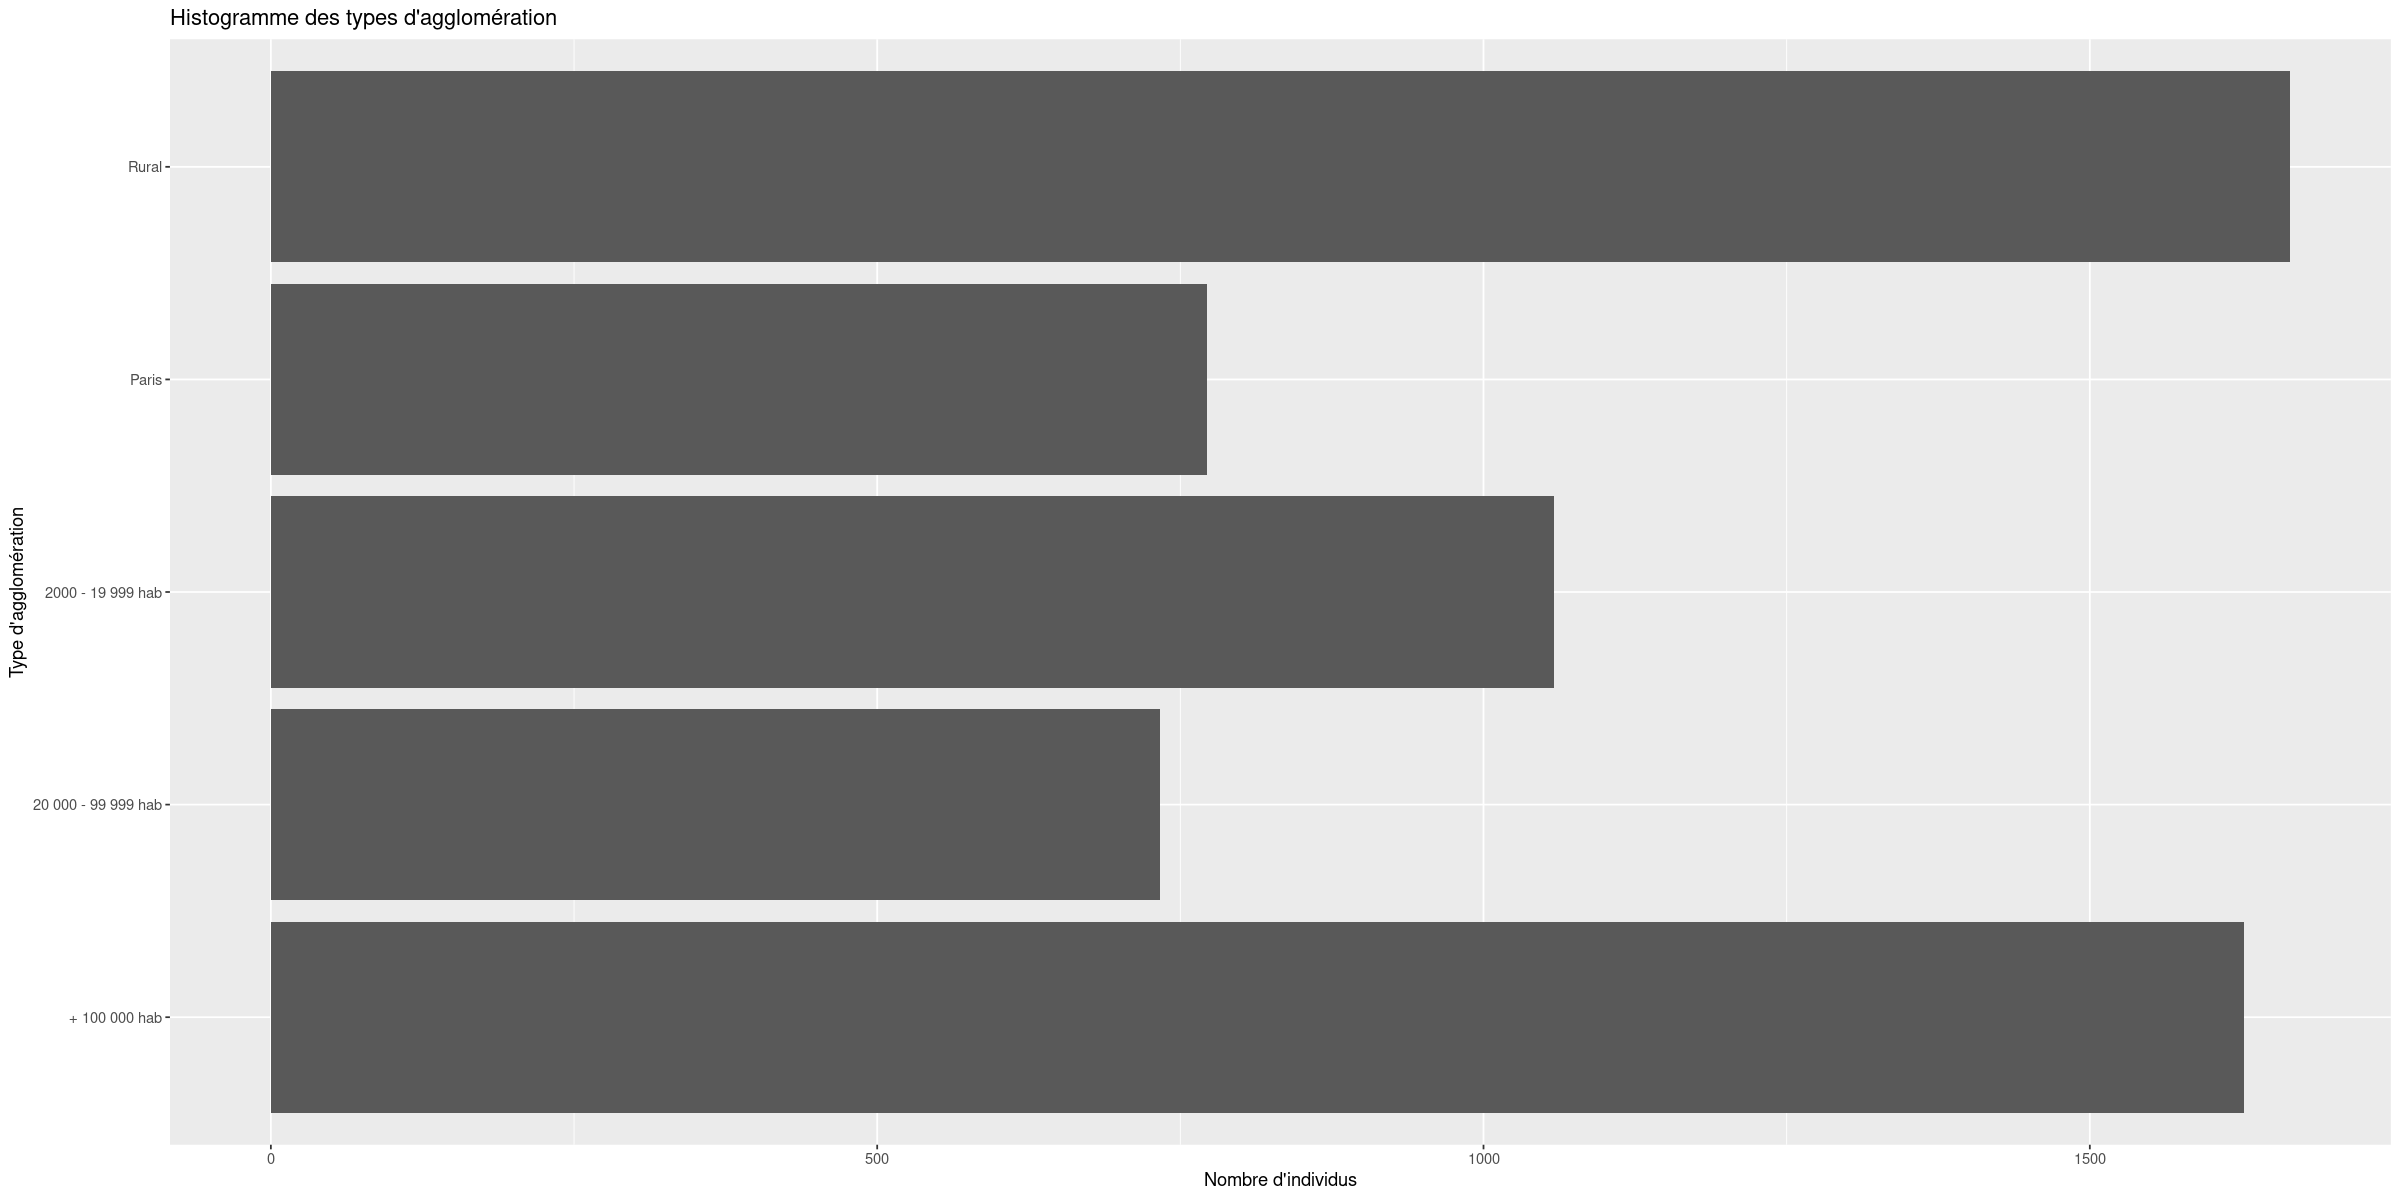

In [12]:
counts_agglo <- description_indiv %>% group_by(categorie_agglo) %>% summarise(n=n())

# Générer le graphique en barres horizontales
ggplot(data=counts_agglo,aes(x=categorie_agglo,y=n))+
    geom_histogram(stat="identity")+
    coord_flip()+ 
    labs(title="Histogramme des types d'agglomération",
          x="Type d'agglomération",
          y="Nombre d'individus")

A vous de jouer, faites la même chose pour les tranches de revenu : histogramme de la variable **RUC_4cl** qui donne le revenu mensuel total du foyer par unité de consommation (UC) en 4 classes. Les modalités de la variable sont les suivantes :

In [13]:
# Niveau de vie

description_indiv <- description_indiv %>% mutate(categorie_ruc=case_when(RUC_4cl==1 ~ "<900 €/mois/UC",
                                                                         RUC_4cl==2 ~ "[900-1 340[ €/mois/UC",
                                                                         RUC_4cl==3 ~ "[1 340-1 850[ €/mois/U",
                                                                         RUC_4cl==4 ~ ">=1 850 €/mois/UC"))


In [14]:
# TODO

### 2. Statistiques bivariées avec les tables _description_indiv_ et _habitudes_indiv_

Quelques exemples de ce qu'il est possible de faire avec ```ggplot2``` :

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


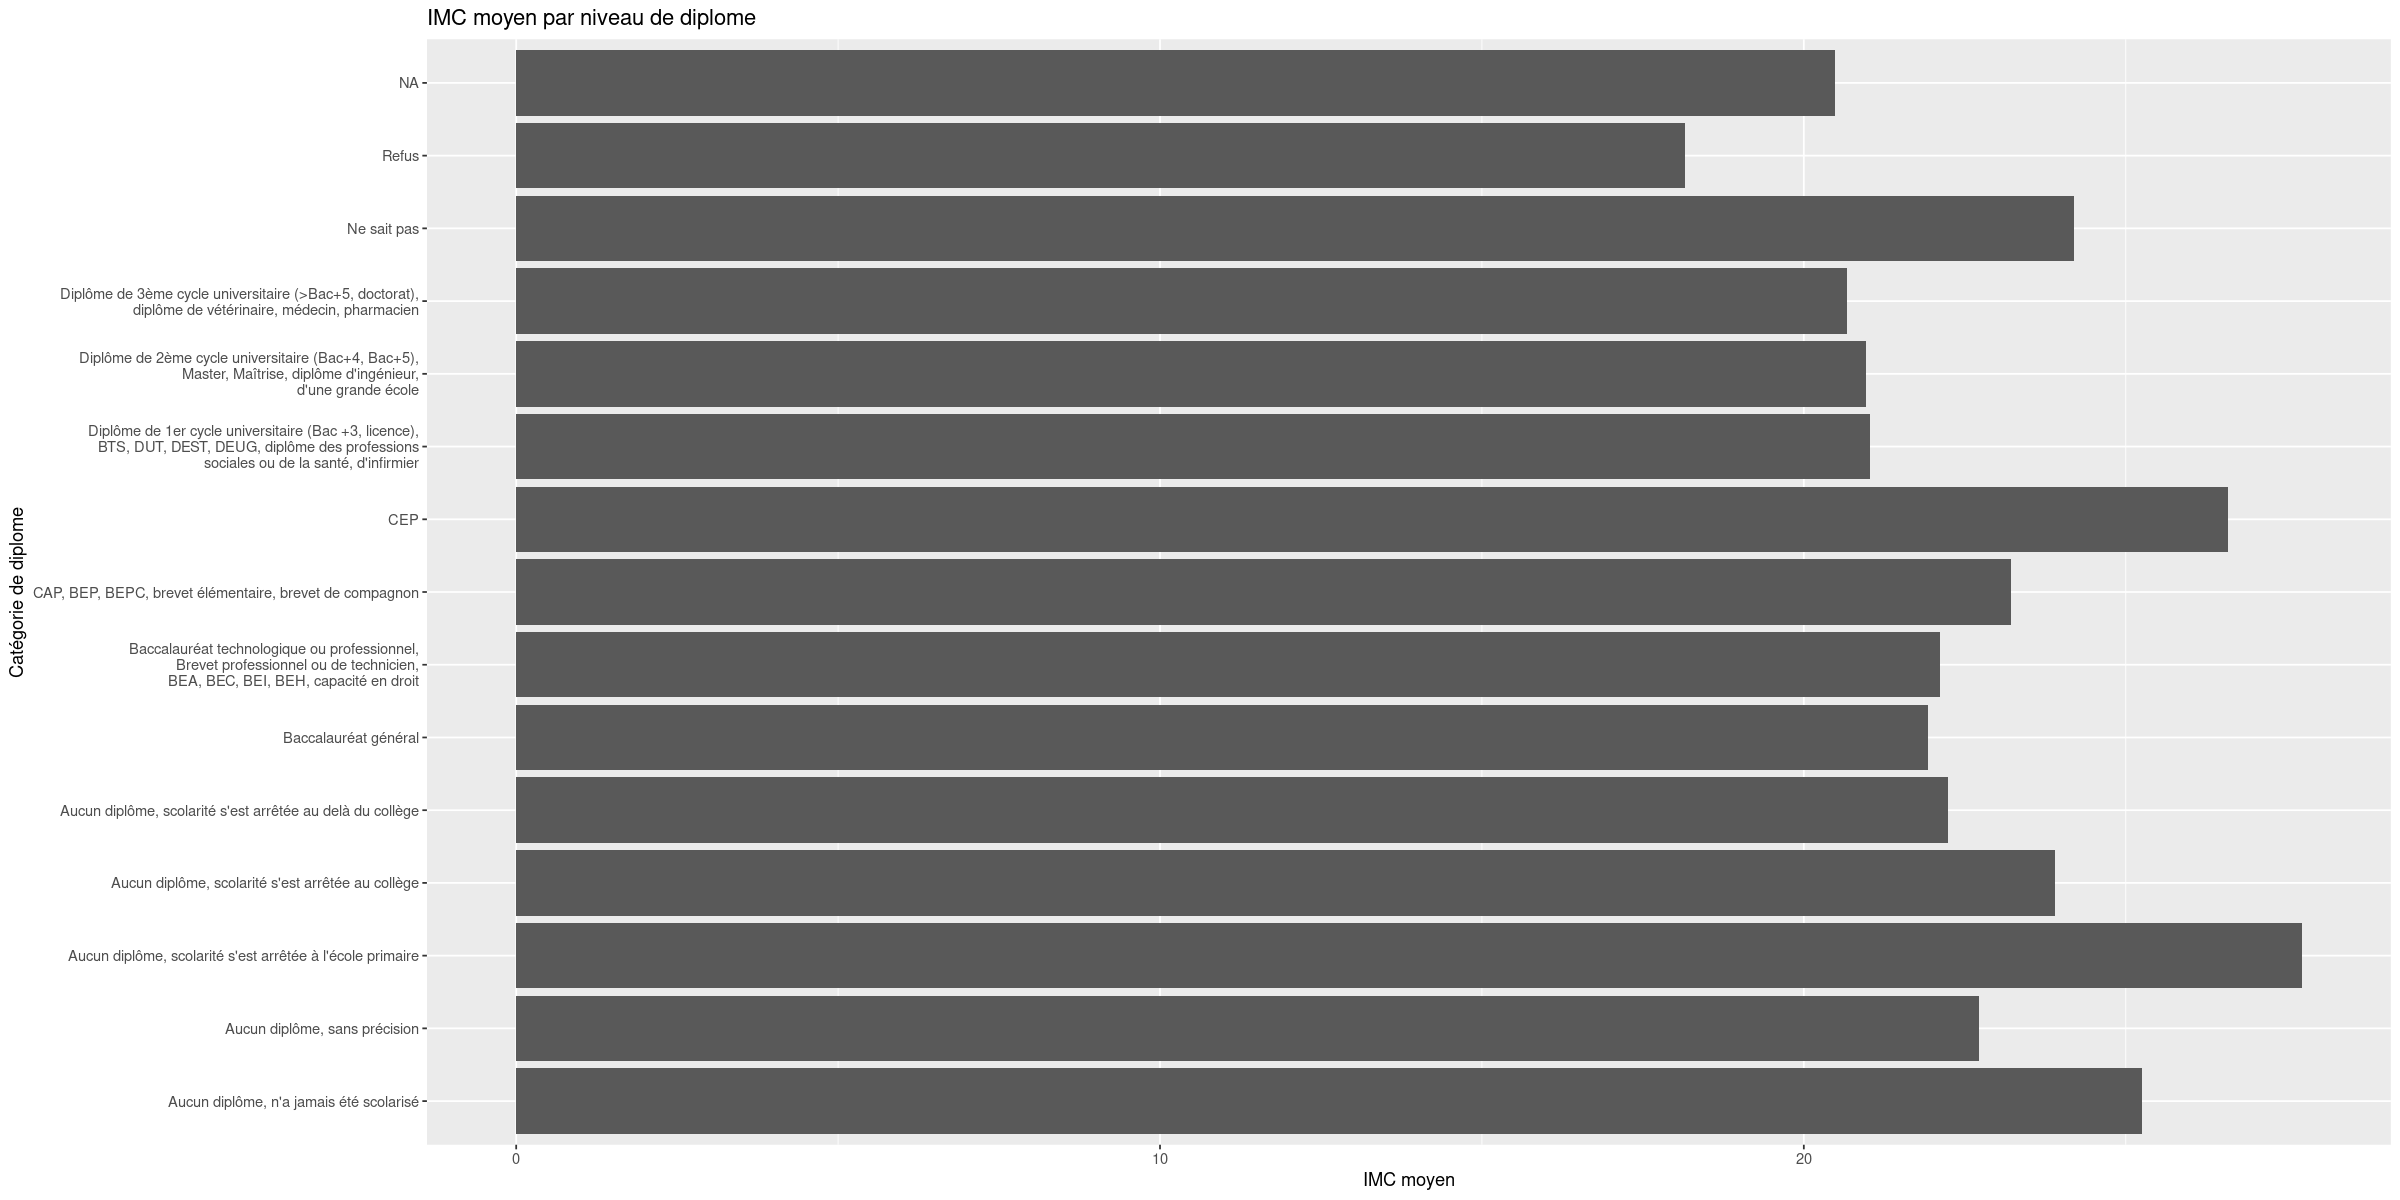

In [15]:
# Imc moyen par niveau de diplôme

imc_par_diplome <- description_indiv %>% group_by(categorie_diplome) %>% summarise(imc_moyen=mean(imc,na.rm=TRUE))

ggplot(data=imc_par_diplome,aes(x=categorie_diplome,y=imc_moyen))+
geom_histogram(stat="identity")+
coord_flip()+
labs(title="IMC moyen par niveau de diplome",
     x="Catégorie de diplome",
     y="IMC moyen")

In [16]:
# Autoproduction par type d'agglomération
description_x_habitudes <- description_indiv %>% left_join(habitudes_indiv,by="NOIND")

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


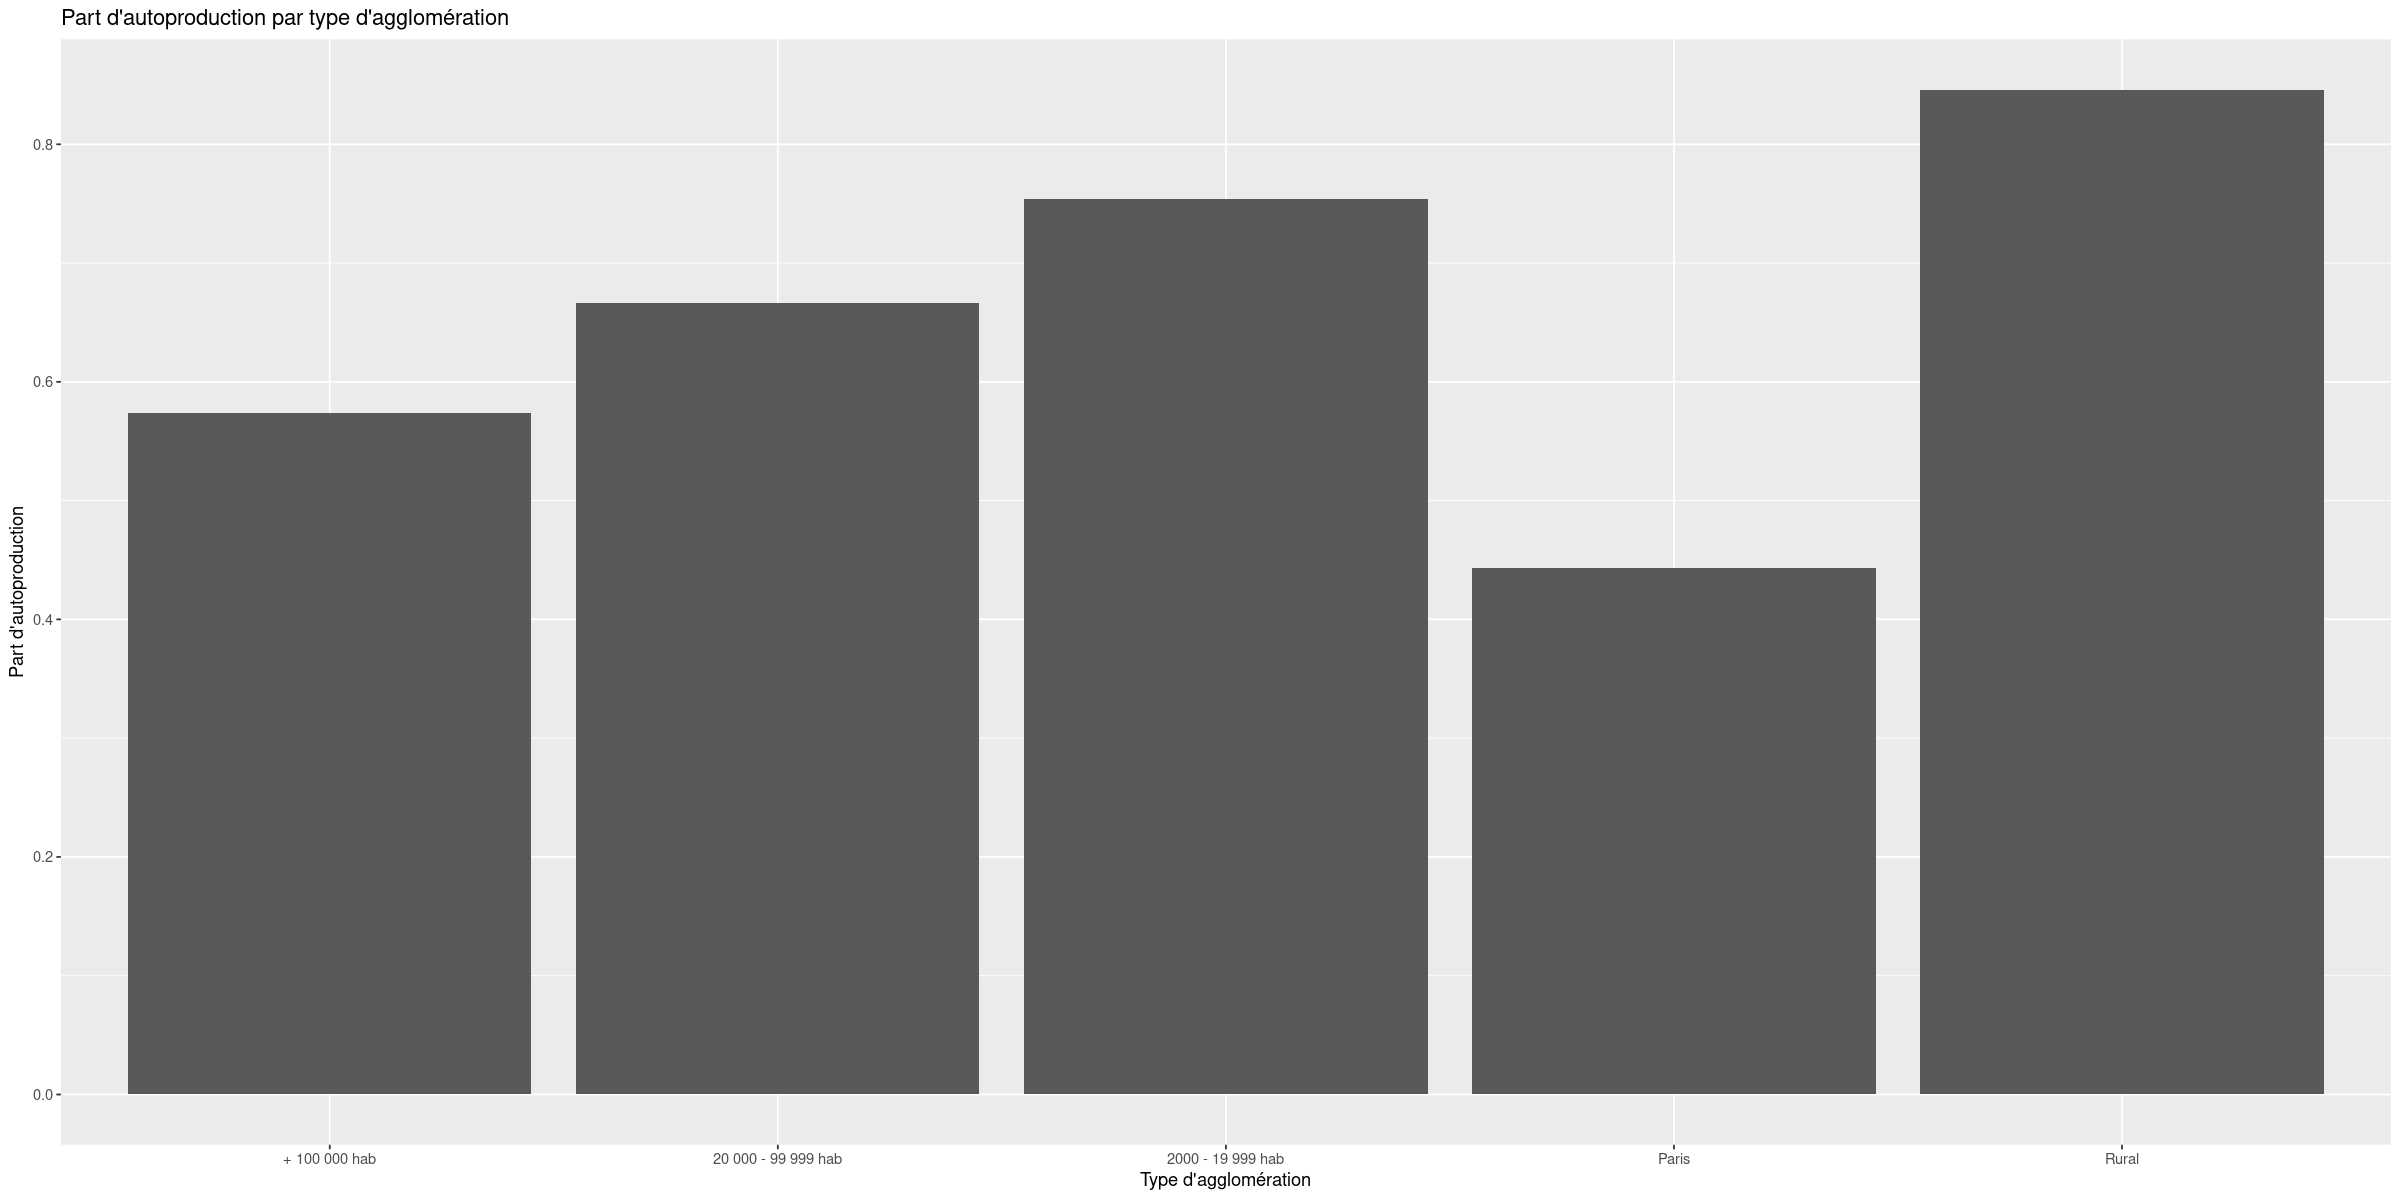

In [17]:
autoprod_par_agglo <- description_x_habitudes %>% group_by(categorie_agglo) %>% summarise(part_autoprod=mean(autoproduction,na.rm=TRUE))
ggplot(data=autoprod_par_agglo,aes(x=categorie_agglo,y=part_autoprod))+
geom_histogram(stat="identity")+
labs(title="Part d'autoproduction par type d'agglomération",
     x="Type d'agglomération",
     y="Part d'autoproduction")

A vous de jouer, représentez le croisement entre le score d'insécurité d'alimentaire (**IA_score**, on peut en faire la moyenne) et les tranches de revenu (par exemple, **RUC_4cl** qu'on a recodée précédemment, ou **revenu** qui donne le revenu disponible codé en plus de classes.)

Le dictionnaire des variables et des modalités peut se trouver ici : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf

In [18]:
# Score d'IA par tranche de revenu

# TODO

Finalement, on se rend compte que la base est très riche et contient beaucoup de variables : beaucoup d'entre elles sont quantitatives, et on peut s'amuser à représenter leurs relations de corrélations en même temps dans une matrice de corrélation.

In [19]:
df_num <- description_x_habitudes %>% select(where(is.numeric))

df_num <- df_num %>% select(c("revenu","IA_score","imc","regime_vegetarien","poidsmax","fume","source_famille","jardin_potager","autoconsommation","consommation_bio"))

matrice_correlation <- model.matrix(~0+., data=df_num) %>% 
  cor(use="pairwise.complete.obs")

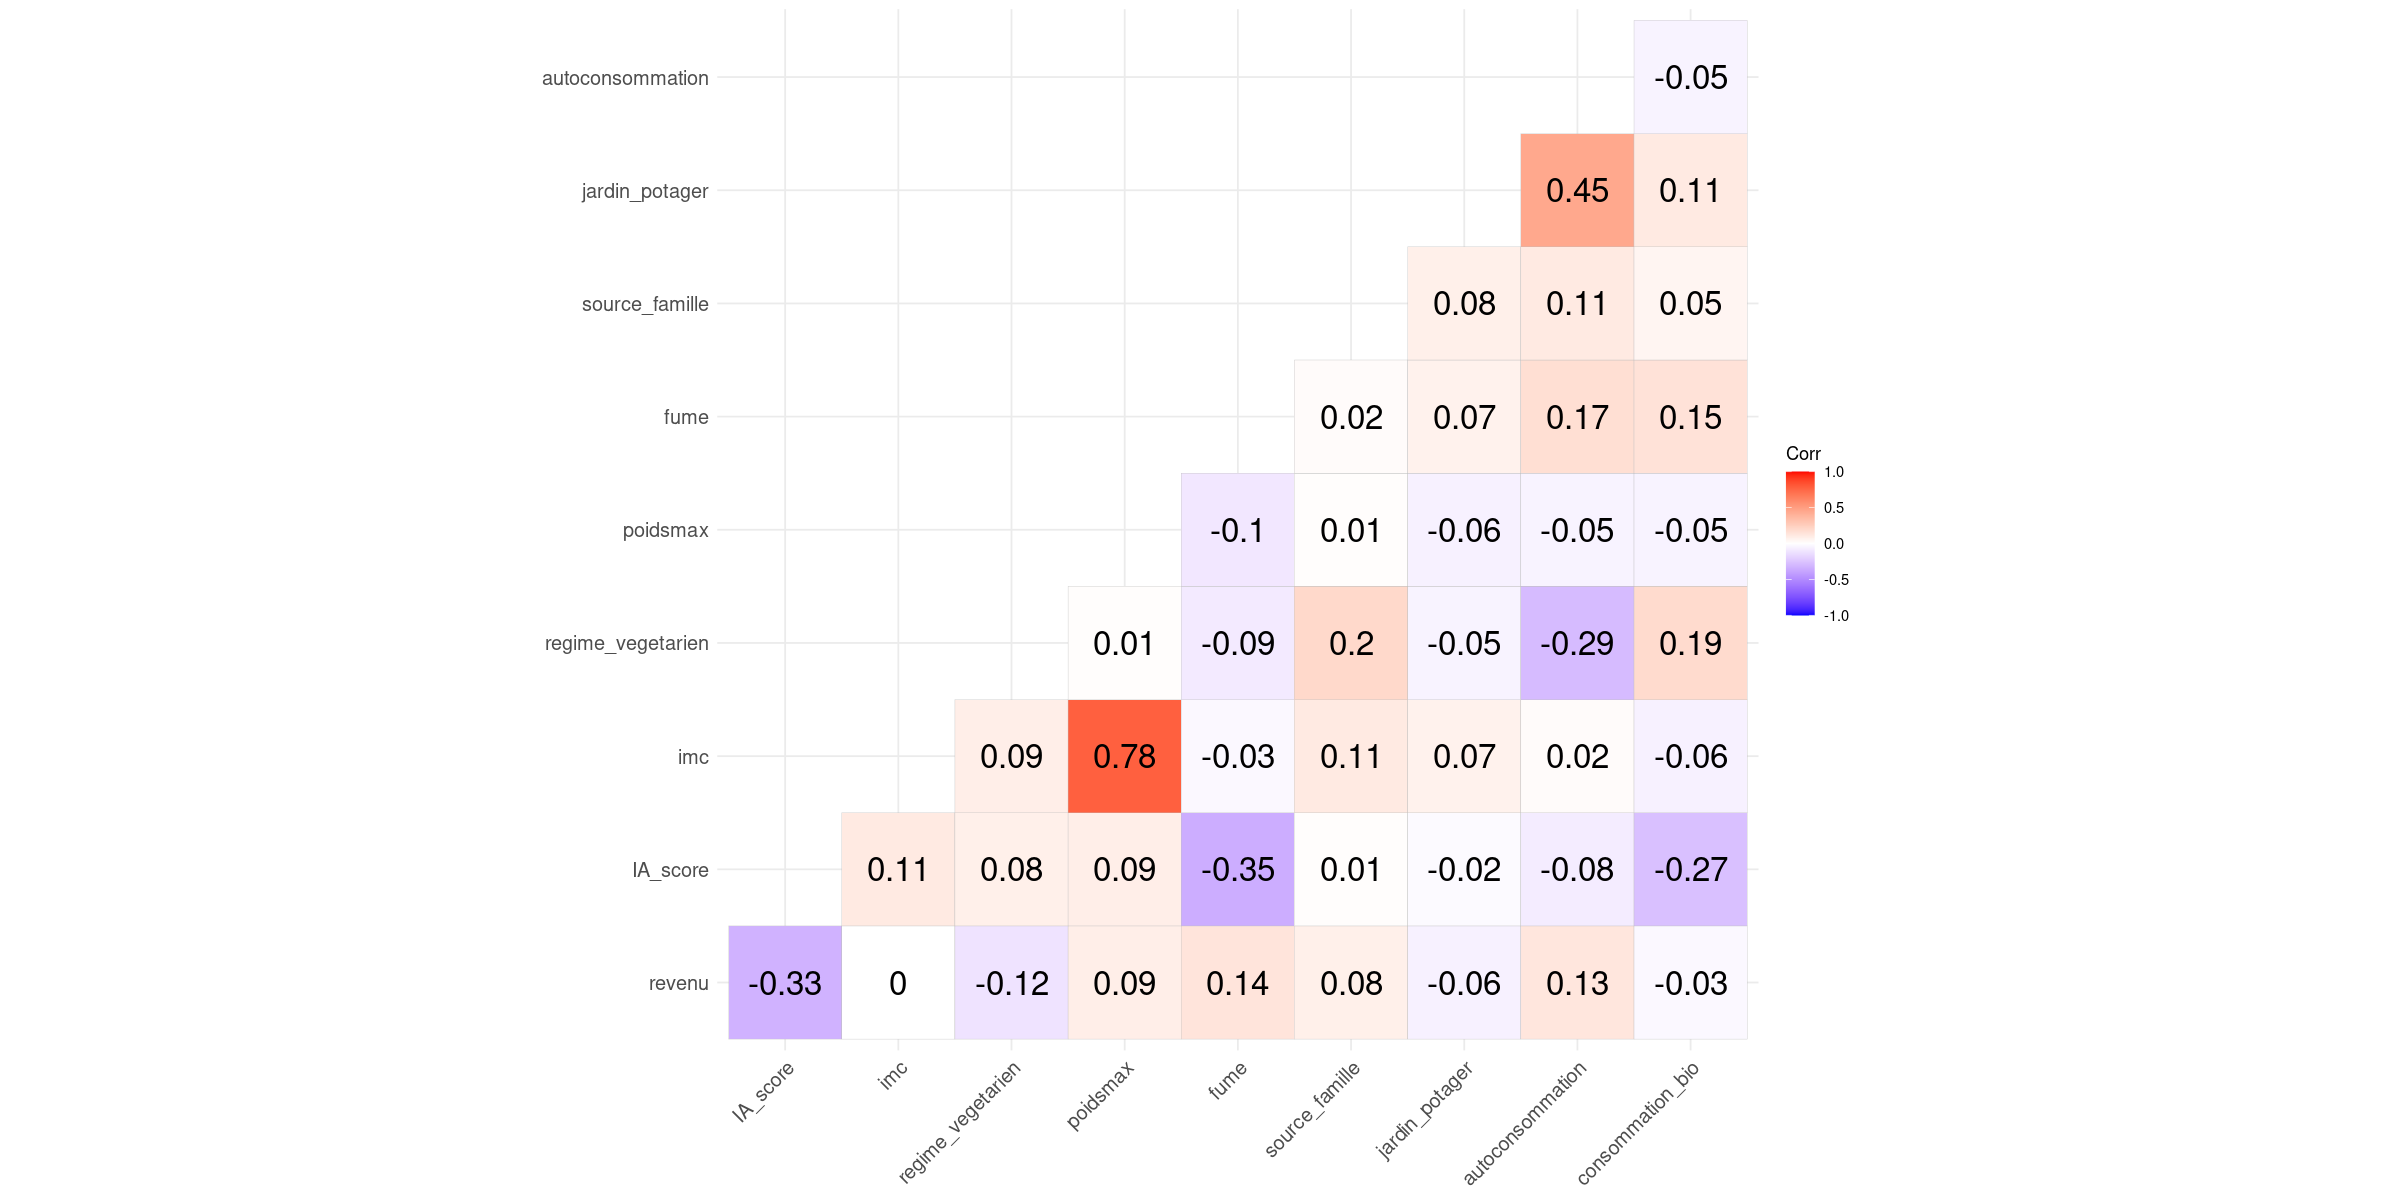

In [20]:
matrice_correlation %>%   ggcorrplot(show.diag=FALSE, type="lower", lab=TRUE, lab_size=7)

A vous d'ajouter les variables qui vous intéressent et à multiplier les visualisations !
Les plus beaux graphes seront partagés à l'issue du funathon.

In [21]:
# TODO

### 3. Cartographie

Pour la cartographie, on a besoin de fonds de carte. Ce sont des bases d'objets vectoriels. Par exemple, pour une carte de France par région, on aura une ligne par région avec un attribut géographique renseignant les coordonnées du vecteur (ou polygone). Le package **cartiflette** nous permet de les télécharger directement et facilement.

In [22]:
url <- "https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year%3D2022/administrative_level%3DREGION/crs%3D4326/FRANCE_ENTIERE%3Dmetropole/vectorfile_format%3D%27geojson%27/provider%3D%27IGN%27/source%3D%27EXPRESS-COG-CARTO-TERRITOIRE%27/raw.geojson"

In [23]:
region <- sf::st_read(url)

Reading layer `raw' from data source 
  `https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year%3D2022/administrative_level%3DREGION/crs%3D4326/FRANCE_ENTIERE%3Dmetropole/vectorfile_format%3D%27geojson%27/provider%3D%27IGN%27/source%3D%27EXPRESS-COG-CARTO-TERRITOIRE%27/raw.geojson' 
  using driver `GeoJSON'
Simple feature collection with 13 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -5.141277 ymin: 41.33356 xmax: 9.560094 ymax: 51.08899
Geodetic CRS:  WGS 84


In [24]:
# Passons le fonds de carte dans le système de coordonnées de référence utilisé pour la FRance, Lambert 93 (code : 2154) au lieu de WGS 84
region <- region %>% st_transform(2154)

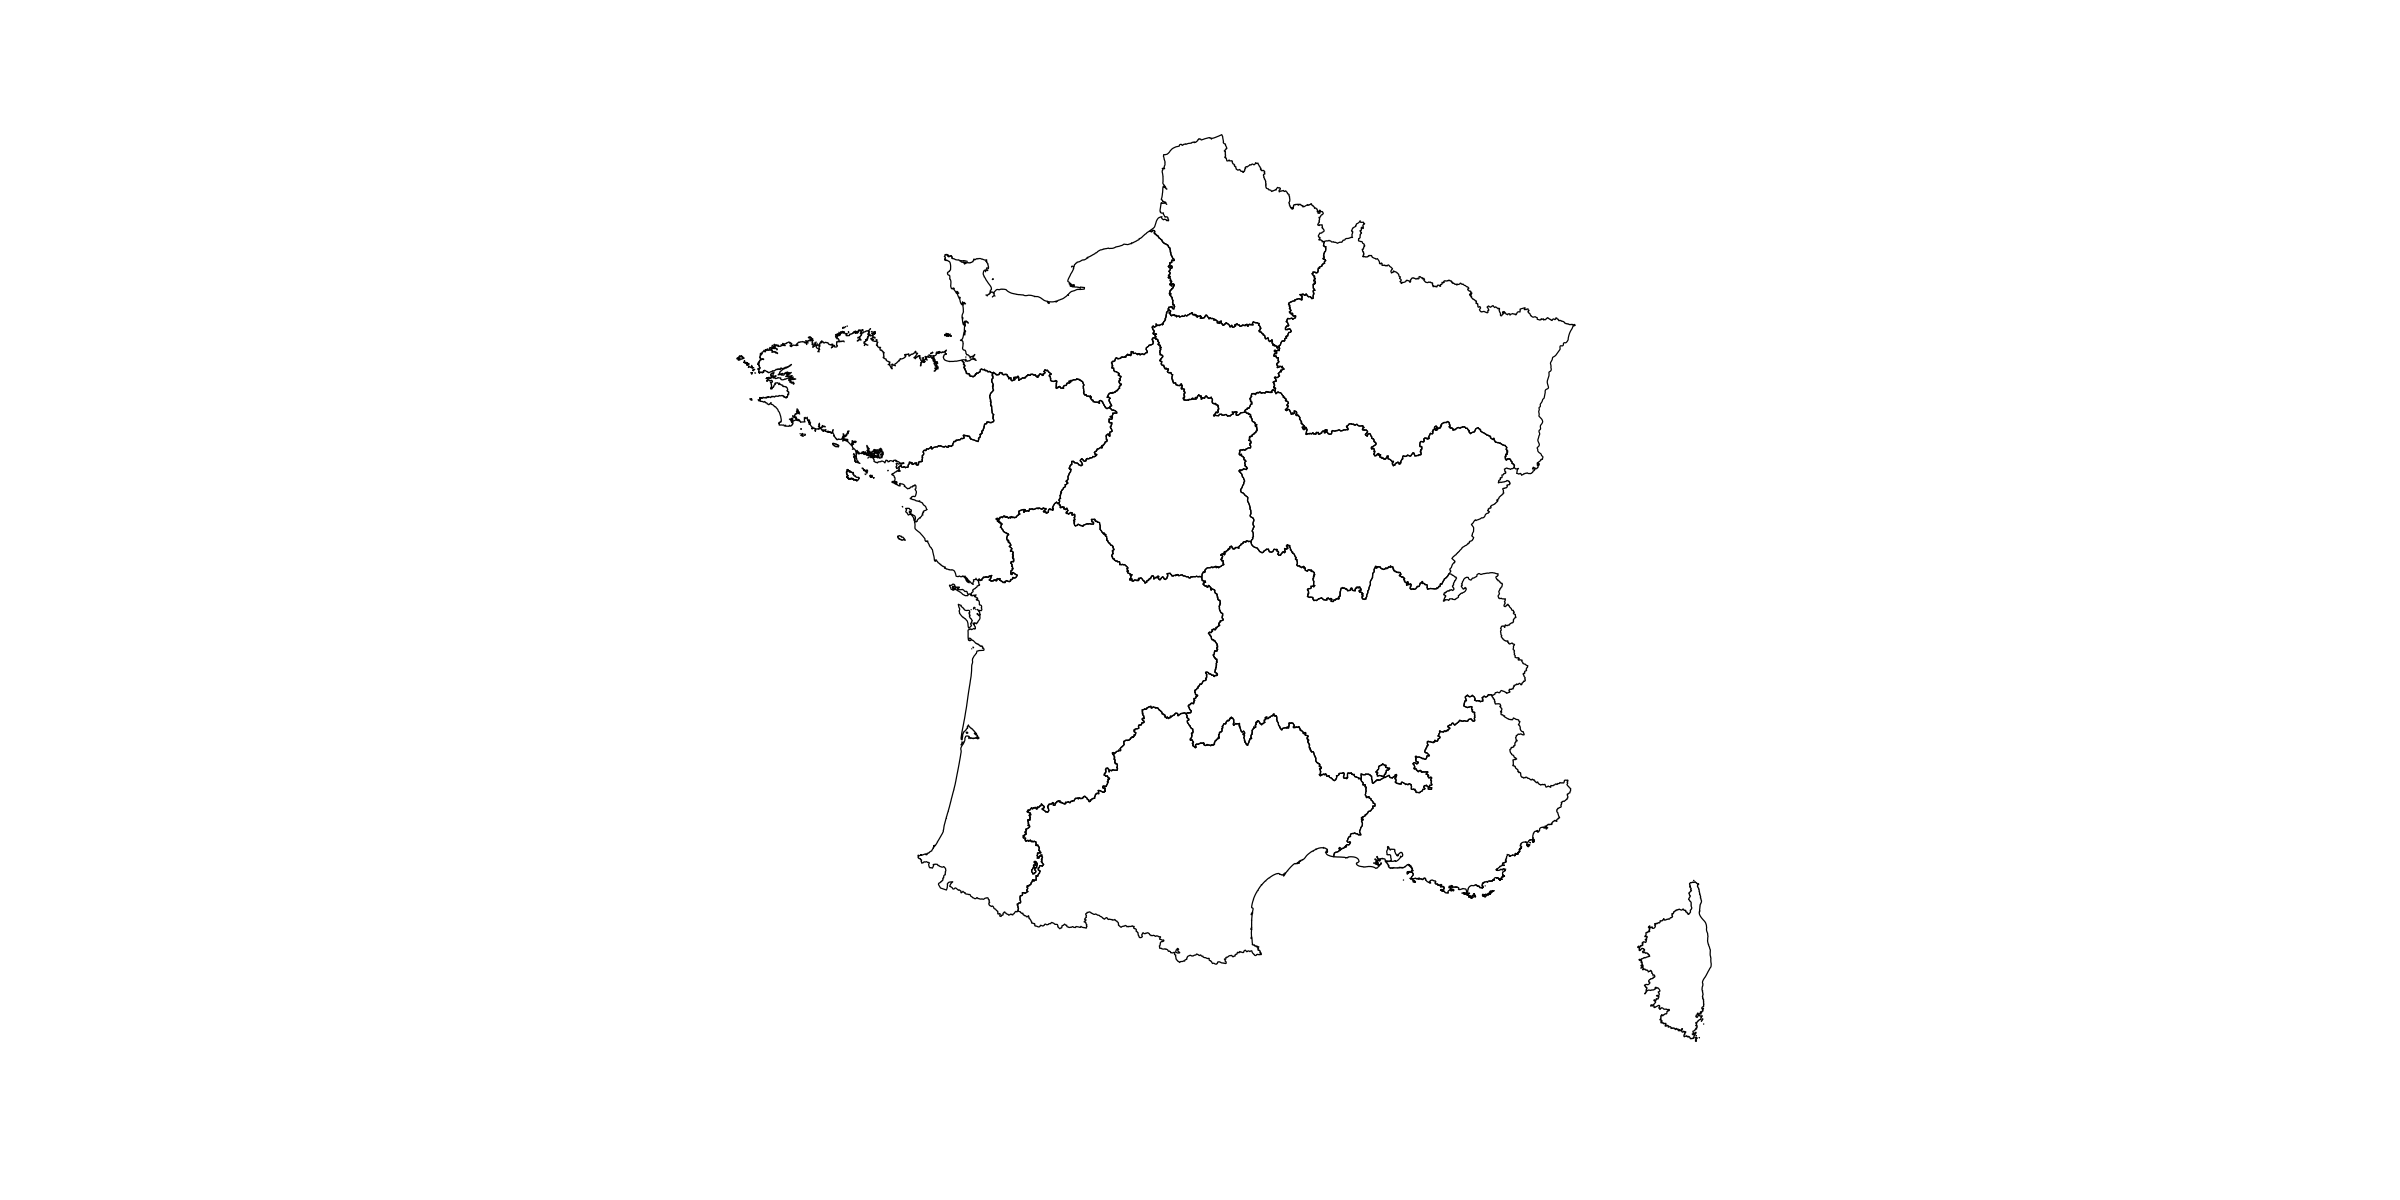

In [25]:
# Représentons les contours de notre fond de carte
plot(st_geometry(region))

In [26]:
region$NOM_M
region <- region %>% mutate(NOM_M=ifelse(NOM_M=="CORSE", "PROVENCE-ALPES-COTE D'AZUR", NOM_M))

[1] "ILE-DE-FRANCE"              "CENTRE-VAL DE LOIRE"       
 [3] "BOURGOGNE-FRANCHE-COMTE"    "NORMANDIE"                 
 [5] "HAUTS-DE-FRANCE"            "GRAND EST"                 
 [7] "PAYS DE LA LOIRE"           "BRETAGNE"                  
 [9] "NOUVELLE-AQUITAINE"         "OCCITANIE"                 
[11] "AUVERGNE-RHONE-ALPES"       "PROVENCE-ALPES-COTE D'AZUR"
[13] "CORSE"

On va s'intéresser aux fréquences de consommation de certains aliments, présentes dans la table fpq.

In [27]:
description_x_fpq = left_join(description_indiv, fpq, by="NOIND")

In [28]:
# Recodage de la variable région pour avoir les mêmes noms que dans notre fond de carte

description_x_fpq <- description_x_fpq %>% mutate(region_recode=case_when(region_adm_12cl==1 ~ "ILE-DE-FRANCE",
                                                                         region_adm_12cl==2 ~ "NORMANDIE",
                                                                         region_adm_12cl==3 ~ "CENTRE-VAL DE LOIRE",
                                                                         region_adm_12cl==4 ~ "PAYS DE LA LOIRE",
                                                                         region_adm_12cl==5 ~ "BRETAGNE",
                                                                         region_adm_12cl==6 ~ "HAUTS-DE-FRANCE",
                                                                         region_adm_12cl==7 ~ "GRAND EST",
                                                                         region_adm_12cl==8 ~ "BOURGOGNE-FRANCHE-COMTE",
                                                                         region_adm_12cl==9 ~ "AUVERGNE-RHONE-ALPES",
                                                                         region_adm_12cl==10 ~ "PROVENCE-ALPES-COTE D'AZUR",
                                                                         region_adm_12cl==11 ~ "OCCITANIE",
                                                                         region_adm_12cl==12 ~ "NOUVELLE-AQUITAINE",))

In [29]:
# Variable à représenter géographiquement : nombre de bière consommées par mois. 

biere_par_region <- description_x_fpq %>% group_by(region_recode) %>% summarise(freq_conso_biere_moyenne=mean(BA_biere_freq_M,na.rm=TRUE))
biere_par_region

region_recode,freq_conso_biere_moyenne
<chr>,<dbl>
AUVERGNE-RHONE-ALPES,5.205775
BOURGOGNE-FRANCHE-COMTE,5.630435
BRETAGNE,6.551802
CENTRE-VAL DE LOIRE,3.404255
GRAND EST,5.797945
HAUTS-DE-FRANCE,6.303672
ILE-DE-FRANCE,4.288275
NORMANDIE,5.388889
NOUVELLE-AQUITAINE,4.390625


In [30]:
# On crée un petit tableau avec nos régions et leurs attributs géographiques, 
# et surtout la variable qu'on vient de calculer (c'est-à-dire le nombre de bières consommées par mois par région en moyenne)

region_inca <- left_join(region,biere_par_region,by=c("NOM_M"="region_recode"))

In [31]:
region_inca$freq_conso_biere_moyenne

[1] 4.288275 3.404255 5.630435 5.388889 6.303672 5.797945 3.769676 6.551802
 [9] 4.390625 4.109873 5.205775 4.062281 4.062281

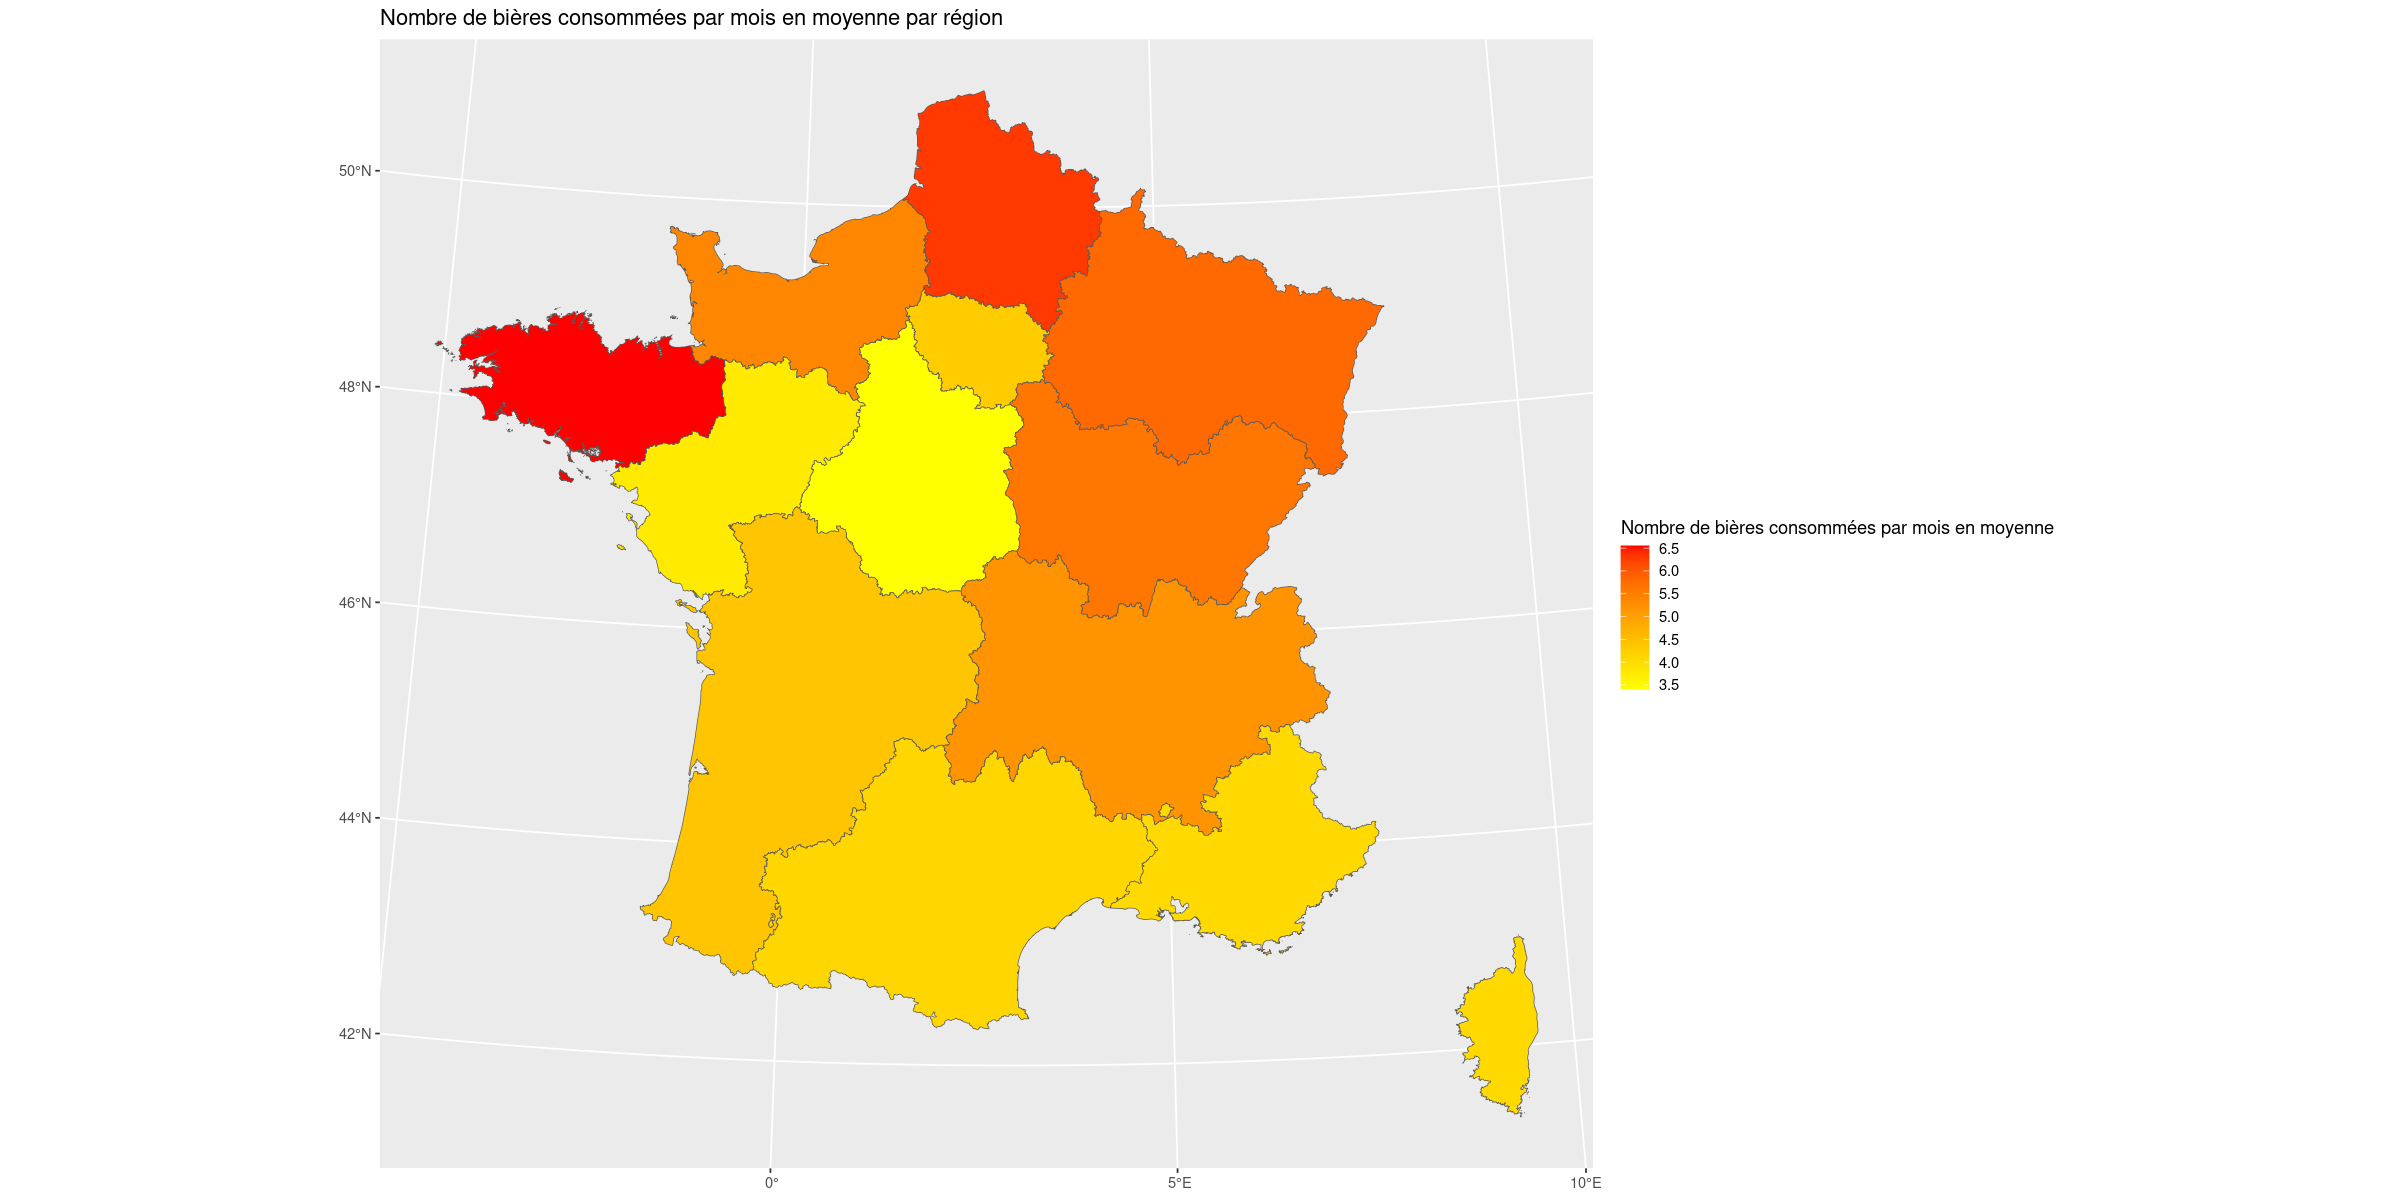

In [32]:
ggplot(data=region_inca) +
geom_sf(aes(fill=freq_conso_biere_moyenne)) +
scale_fill_continuous(low="yellow", high="Red", name="Nombre de bières consommées par mois en moyenne") +
labs(title="Nombre de bières consommées par mois en moyenne par région")

Maintenant, créez votre propre carte ! Vous pouvez regarder directement dans le dictionnaire des variables, ou bien vous aider des libellés.
Les fréquences en nombre de jours par mois finissent par _freq_M, et les indicatrices de consommation finissent par _ON (ces dernières valent 1 si le produit est consommé et 0 sinon). 

Par exemple, on peut choisir parmi les variables dans : ```colnames(fpq)```

In [33]:
# TODO

## Partie 2 : Clustering d'individus

Premier point de contact : Antoine Palazzolo

Lorsque l'on pense au Machine Learning, les premiers exemples qui viennent en tête sont souvent des problèmes de régression ou bien de classification.
Ces cas d'usage font partie d'une branche du ML appelée _apprentissage supervisé_, qui requiert notamment d'avoir des données labellisées permettant aux diverses méthodes utilisées de comprendre la relation entre un ensemble de variables explicatives et une variable à prédire.

_L'apprentissage non supervisé_ est une autre branche du ML qui ne consiste cette fois plus à prédire une variable donnée à partir de données labellisées.
Au coeur de l'apprentissage non supervisé on trouve notamment le __clustering__.
Cette fois-ci, le but est de créer à partir d'une population donnée un ensemble de clusters (ou paquets) d'individus regroupés par similarité, en utilisant de façon automatiques les caractéristiques les plus discriminantes de notre population. Ce sera peut-être plus clair avec quelques exemples et applications :
- Une enseigne de retail possède une centaine de magasins en France et souhaite regrouper ces derniers en une poignée de groupes qu'elle pourra approvisionner de la même façon. Chaque groupe devra regrouper des magasins ayant des performances similaires et une clientèle proche. C'est un problème de clustering.
- A partir d'une base de données regroupant les thèmes de prédilection de centaines de journalistes (ou bien leurs références), on souhaite regrouper ces mêmes journalistes en quelques catégories au sein desquelles chaque individu aura une orientation politique proche de celles des autres.
- En fonction des caractéristiques physiques d'espèces animales ou végétales, on souhaite regrouper ces espèces en un plus petit nombre de groupes.



Il existe plusieurs méthodes pour faire du clustering, les deux plus connues étant :
- Les [K-Moyennes](https://fr.wikipedia.org/wiki/K-moyennes) (ou K-Means), méthode la plus connue, basée sur l'utilisation de centroïdes itérés
- Le [Clustering Ascendant Hiérarchique](https://fr.wikipedia.org/wiki/Regroupement_hi%C3%A9rarchique) (CAH), basé sur des regroupements en groupes de plus en plus grands, donnant par exemple lieu à des visualisations sous forme de dendrogrammes (ressemblant aux arbres phylogénétiques de vos cours de SVT au lycée)

Nous allons mettre en pratique ces deux méthodes dans ce sujet.

Une fois nos clusterings effectués, l'un des enjeux est ensuite aussi de pouvoir interpréter ces derniers :
- Quelles sont les caractéristiques les plus discriminantes dans la constitution des groupes ?
- Les clusters générés font-ils bien sens ? Que peut-on dire de ces groupes ?
- Quelles méthodes de visualisation sont les plus adaptées ?

Pour répondre à ces questions, un des outils principaux que nous pouvons utiliser est l'[Analyse en Composantes Principales](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales) (ACP), qui à partir de l'ensemble initial des colonnes en crée un ensemble de taille réduite qui maximise la discrimination des données les unes par rapport aux autres via ces nouvelles colonnes.
En réduisant la dimension à moins de 3, on peut ainsi représenter graphiquement les données de façon plus claire.

### 1. Preprocessing des données

Pour cette étude nous allons commencer par la table des habitudes individuelles.
Cette table contient les données des questionnaires auto-administrés relatifs aux volets « Habitudes alimentaires » et « Origine des aliments ».

Elle regroupe les informations suivantes : lieux et occasions de consommation, consommations hors-foyer et entre les repas, préférences alimentaires, présence de sel/beurre/sauce sur la table au moment des repas, lecture des étiquettes, sources d’informations en alimentation, consommation de denrées animales crues et des croûtes de fromage, préparation des fruits et légumes crus, spécificités de l’alimentation des enfants de 0 à 35 mois (ex : allaitement (exclusif ou partiel), type de laits consommés, diversification alimentaire, matériaux des biberons et des tétines, préparation, stockage et conservation des biberons de lait, mode de chauffage des laits et contenants utilisés), autoconsommation et utilisation de produits phytosanitaires au potager, consommation d’aliments issus de l’agriculture biologique et cuisson des aliments au barbecue.

Une fois le sujet terminé, vous pourrez si vous le souhaitez reproduire cette partie avec d'autres des tables à disposition.

In [34]:
# Dimensions de habitudes_indiv
n_rows <- nrow(habitudes_indiv)
n_cols <- ncol(habitudes_indiv)

# Affichage des dimensions
print(paste("Nombre de lignes :", n_rows))
print(paste("Nombre de colonnes :", n_cols))

[1] "Nombre de lignes : 4372"
[1] "Nombre de colonnes : 389"


In [35]:
head(habitudes_indiv, 3)

POPULATION,NOIND,periode_reference,repasenfantmidi_vous,repasenfantmidi_am,repasenfantmidi_creche,repasenfantmidi_parent,repasenfantmidi_autre,repasenfantmidi_autre_libelle,repasenfant_freq,⋯,conso_legumes_secs_bio_tjr_svt,conso_cereales_bio_tjr_svt,conso_pain_bio_tjr_svt,conso_autres_alim_bio_tjr_svt,conso_barbecue,conso_barbecue_elec,conso_barbecue_bois,conso_barbecue_gaz,conso_barbecue_printps_ete_freq,conso_barbecue_automn_hiver_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pop2 Individu,110100101,4,NA,NA,NA,NA,NA,NA,NA,⋯,NA,0,0,NA,1,0,1,0,3,1
Pop2 Individu,110100701,4,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0,NA,1,0,1,1,4,1
Pop2 Individu,110100801,4,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0,0,1,0,1,0,3,2


#### Etape 1 : Analyse exploratoire & sélection de variables

Regardons déjà à quoi ressemblent nos données en pratique. En utilisant dplyr, pouvez-vous dire :
- Combien y a-t-il d'individus et de variables ?
- Combien de variables présentent des valeurs vides ? En quelle proportion ?
- Y a-t-il des variables qui ont la même valeur pour tous les individus ? Seront-elles utiles pour la discrimination des observations dans le clustering ?
- Y a-t-il des variables qui n'ont pas de sens pour la caractérisation d'un groupe ? Cela comprend par exemple les identifiants.
- Quels sont les types des variables ? Combien de variables non-numériques ? En pratique nous allons ici nous focaliser uniquement sur les données numériques de la table.

In [36]:
# A vous de jouer !

# TODO

A partir des analyses que vous venez de réaliser, vous devriez avoir une meilleure idée de quoi garder dans la table pour appliquer les méthodes de clustering. Créez donc ```habitudes_indiv_clustering_1``` à partir de ```habitudes_indiv``` en retirant toutes les colonnes gênantes ou inutiles :

<details>
<summary> Si besoin, dérouler pour révéler les indications plus détaillées :</summary>
<br>

Il vous faudra donc, a minima :
- Retirer les colonnes d'identifiants
- Retirer les colonnes vides
- Conserver uniquement les colonnes numériques

Pour aller plus loin, retirez les colonnes à moins de 2 valeurs distinctes.

</details>


In [37]:
habitudes_indiv_clustering_1 <- data.frame() # TODO

In [38]:
# Dimensions de habitudes_indiv
n_cols <- ncol(habitudes_indiv_clustering_1)

# Affichage des dimensions
print(paste("Nombre de colonnes :", n_cols))

[1] "Nombre de colonnes : 0"


<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
# Sélectionner les caractéristiques pour le clustering
habitudes_indiv_clustering_1 <- habitudes_indiv %>%
  select(-c(POPULATION, NOIND, periode_reference)) %>%  # Identifiants
  select_if(function(col) any(!is.na(col))) %>%  # Colonnes vides
  select_if(is.numeric) %>%  # Colonnes numériques à garder
  select_if(function(col) length(unique(col)) > 1)  # On retire les colonnes avec moins de 2 valeurs distinctes
```

</details>


#### Etape 2 : Imputation

Comme vous l'avez peut-être vu, si l'on cherche à retirer toutes les lignes ou colonnes avec au moins une valeur manquante, il ne reste plus grand-chose à la table...
Nous allons donc les garder, d'autant plus que cela ne les empêche pas de contenir de l'information importante.

Dans ce cas comment traiter les NaNs ?
Il existe une méthode pour les remplacer par une valeur numérique, il s'agit de l'__[imputation](https://fr.wikipedia.org/wiki/Imputation_(statistique))__.

Plusieurs méthodes d'imputation existent : remplacer les valeurs manquantes par la moyenne de la colonne, par une valeur issue de régression linéaire, de régression stochastique, etc.

Dans notre cas particulier, la plupart des variables sont binaires, des réponses Oui/Non à une question.
Une méthode que nous pouvons donc utiliser (mais d'autres marcheraient très bien aussi) est l'imputation par la valeur non vide la plus fréquente de la colonne.

En termes d'interprétation, cela revient à simplifier le problème en considérant que les non-répondants auraient répondu la même chose que la majorité des répondants, quitte à ce que cela mène à de possibles erreurs.
Par exemple, les répondants "Homme" ont peu de chances de répondre "Oui" à l'allaitement, mais c'est une solution qui fonctionne tout de même en général très bien.

<br>

A présent, appliquez cette stratégie d'imputation sur la table ```habitudes_indiv_clustering_1``` pour donner naissance à ```habitudes_indiv_clustering_2```.

In [39]:
habitudes_indiv_clustering_2 <- data.frame() # TODO

In [40]:
# Dimensions de habitudes_indiv
n_cols <- ncol(habitudes_indiv_clustering_2)

# Affichage des dimensions
print(paste("Nombre de colonnes :", n_cols))

[1] "Nombre de colonnes : 0"


<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
Mode <- function(x) {
  non_missing_values <- x[!is.na(x)]
  ux <- unique(non_missing_values)
  ux[which.max(tabulate(match(non_missing_values, ux)))]
}

# Remplacer les valeurs manquantes (NaN) par le mode
habitudes_indiv_clustering_2 <- habitudes_indiv_clustering_1 %>%
  mutate_all(~ifelse(is.na(.), Mode(.), .)) %>%
select_if(function(col) length(unique(col)) > 1)  # On re-retire les colonnes avec moins de 2 valeurs distinctes pour s'éviter des erreurs par la suite
```

</details>


#### Etape 3 : Normalisation des colonnes

Pour la plupart des méthodes que nous allons utiliser, nous ne souhaitons pas nécessairement donner plus d'importance à une colonne qu'à une autre.
Or pour plusieurs des fonctions que nous allons manipuler, le poids affecté à une colonne peut dépendre de sa moyenne ou de sa variance.

Ici, les questions étant pour la plupart binaires, nous ne voulons pas qu'une question avec davantage de réponses positives ait une importance plus grande qu'une autre.
Nous devons donc renormaliser les colonnes pour corriger ce problème.

A vous de jouer : renormalisez l'ensemble des colonnes pour amener leur moyenne à 0 et leur variance à 1. Vous stockerez le résultat dans le tableau ```habitudes_indiv_clustering_3```.

In [41]:
habitudes_indiv_clustering_3 <- data.frame() # TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
# Normalisation des colonnes
habitudes_indiv_clustering_3 <- scale(habitudes_indiv_clustering_2)
```

</details>


#### Etape 4 : Gestion des outliers

Dans ce type de questionnaire il n'est pas rare de trouver des observations aberrantes, par exemple en raison d'individus répondant de façon absurde aux questions.
De façon générale, si la base de données est suffisamment grande et que l'on ne s'intéresse pas nécessairement à chaque individu, une bonne pratique peut être de retirer les outliers de notre base.
Cela permet en effet de limiter les risques d'avoir des clusters à un seul individu ne représentant rien d'intéressant ou d'avoir des visualisations déformées par une observation très loin par rapport aux autres.

A vous de jouer : retirez les outliers de la table ```habitudes_indiv_clustering_3```, disons 3% des observations, et stockez le résultat dans la table ```habitudes_indiv_clustering_4```.

Vous pouvez importer et utiliser le package ```isotree```, notamment les méthodes ```isolation.forest()``` et ```predict()```.

In [42]:
habitudes_indiv_clustering_4 <- data.frame() # TODO

In [43]:
# Dimensions de habitudes_indiv
n_rows <- nrow(habitudes_indiv_clustering_4)

# Affichage des dimensions
print(paste("Nombre de lignes restantes :", n_rows))

[1] "Nombre de lignes restantes : 0"


<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
library(isotree)

outlier_detector <- isolation.forest(habitudes_indiv_clustering_3)
is_outlier_scores <- predict(outlier_detector, habitudes_indiv_clustering_3)
sorted_oulier_scores <- order(is_outlier_scores)

nb_observations_to_keep <- round(0.97 * nrow(habitudes_indiv_clustering_3))
habitudes_indiv_clustering_4 <- habitudes_indiv_clustering_3[sorted_oulier_scores[1:nb_observations_to_keep], ] %>%
select_if(function(col) length(unique(col)) > 1)  # On re-retire les colonnes avec moins de 2 valeurs distinctes pour s'éviter des erreurs par la suite
```

</details>

Si vous le souhaitez, vous pourrez dans un second temps reproduire la suite sans retirer les outliers pour comparer les résultats obtenus.

<br>

Vous avez à présent terminé le preprocessing de la table pour la partie Clustering.
Libre à vous de rajouter des opérations supplémentaires si vous en voyez le besoin.
Sinon nous pouvons rentrer dans le vif du sujet.

Pour simplifier les notations, exécutez la cellule ci-dessous :

In [44]:
habitudes_indiv_clustering <- as.data.frame(habitudes_indiv_clustering_4) %>%
select_if(function(col) length(unique(col)) > 1)  # On re-retire les colonnes avec moins de 2 valeurs distinctes pour s'éviter des erreurs par la suite

dim(habitudes_indiv_clustering)

[1] 0 0

### 2. Le clustering en lui-même

Dans cette partie, nous allons mettre en pratique les 2 méthodes de clustering les plus classiques :
- Les K-Moyennes (ou K-Means)
- Le Clustering Ascendant Hiérarchique (CAH)

#### K-Moyennes

Dans ce sujet, nous ne revenons pas sur la théorie derrière l'algorithme du K-Means.
Donc si vous êtes intéressés pour savoir ce qui se passe derrière l'utilisation du package en boîte noire, la documentation sur cette thématique est largement disponible sur Internet.

##### Choisir le nombre de clusters

Une particularité des K-moyennes est qu'il faut choisir en amont de l'application de l'algorithme le nombre de clusters (ou de centroïdes) ```k```, a priori sans savoir quel serait le nombre optimal.
Il existe plusieurs méthodes pour faire ce choix :
- S'il existe des contraintes métier ou des interprétations relatives au "monde réel" imposant une valeur de ```k```
- En utilisant la méthode dite du __coude__, qui est la façon la plus simple d'avoir une idée de ```k``` à utiliser.
    + Le principe est de lancer le K-means avec plusieurs valeurs de ```k```, représenter une mesure de la distance moyenne intra-clusters en fonction de ```k``` et trouver le premier point d'inflexion
    + En revanche, le ```k``` renvoyé n'est pas toujours stable et parfois peu pertinent.
- En utilisant la méthode dite de __silhouette__, méthode a priori plus fine mais un peu plus complexe que celle du coude
    + Le score à maximiser par rapport à ```k``` est cette fois la moyenne d'une mesure de la similitude d’une observation à l’intérieur d’un groupe par rapport à d’autres groupes pour chaque point

A titre d'exemple, utilisez la méthode du coude pour trouver le nombre optimal de clusters pour les données de ```habitudes_indiv_clustering```. On cherchera un ```k``` compris entre 1 et 10.

Vous pouvez importer et utiliser la fonction ```fviz_nbclust()``` du package ```factoextra```.

In [45]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
library(factoextra)
library(cluster)

# Méthode du coude
elbow_method <- fviz_nbclust(habitudes_indiv_clustering, kmeans, method = "wss", k.max = 10)
elbow_method
```

</details>

A présent faites la même chose mais avec la méthode de Silhouette :

In [46]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
# Méthode de Silhouette
silhouette_method <- fviz_nbclust(habitudes_indiv_clustering, kmeans, method = "silhouette", k.max = 10)
silhouette_method
```

</details>

Quel est le ```k``` obtenu ? Cette valeur reste-t-elle la même si vous lancez la méthode plusieurs fois ?

S'il n'y a pas de point d'inflexion (ou coude) bien défini sur le premier graphique produit, la valeur peut souvent varier. Pour la suite du sujet, nous conserverons une valeur fixe, que vous pourrez modifier par la suite si vous le souhaitez. Exécutez la ligne ci-dessous :

In [47]:
k_kmeans <- 3

##### Le clustering en lui-même

Une fois les données préprocessées et le ```k``` déterminé, clusteriser les données n'est plus très difficile.

Créez le vecteur ```clusters_kmeans``` des clusters obtenus par la méthode des K-moyennes :

In [48]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
k_moyennes <- kmeans(habitudes_indiv_clustering, centers = k_kmeans, nstart = 20)

# Assignation des clusters
clusters_kmeans <- k_moyennes$cluster
```

</details>

Félicitations, vous avez désormais vos clusters !
Pouvez-vous dire quelle est la taille de chacun ? Ces valeurs sont-elles proches les unes des autres ? Pouvez-vous déjà interpréter vos résultats ?

In [49]:
# TODO

On a certes obtenu nos clusters, mais tout cela n'est pas encore très visuel...

Mais pas de panique, plus que quelques cellules à attendre pour passer à la visualisation par ACP !

#### Clustering Ascendant Hiérarchique

Avant de passer à la visualisation, nous allons nous attarder sur une autre méthode de clustering, à peu près équivalente aux K-moyennes en termes de performances, mais dont les résultats sont beaucoup plus visuels : le [CAH](https://www.xlstat.com/fr/solutions/fonctionnalites/classification-ascendante-hierarchique-cah). Comment est-ce que ça marche ?

- On commence par calculer la dissimilarité entre nos N individus, ie leur distance deux à deux dans l'espace de nos variables
- Puis on regroupe les deux individus dont le regroupement minimise un critère d'agrégation donné, créant ainsi une classe comprenant ces deux individus.
- On calcule ensuite la dissimilarité entre cette classe et les N-2 autres individus en utilisant le critère d'agrégation.
- Puis on regroupe les deux individus ou classes d'individus dont le regroupement minimise le critère d'agrégation.
- On continue ainsi jusqu'à ce que tous les individus soient regroupés.

Ces regroupements successifs produisent un arbre binaire de classification (_dendrogramme_), dont la racine correspond à la classe regroupant l'ensemble des individus.
Ce dendrogramme représente une hiérarchie de partitions.
On peut alors choisir une partition en tronquant l'arbre à un niveau donné, le niveau dépendant soit des contraintes de l'utilisateur, soit de critères plus objectifs.

<br>

Dans ce sujet, nous allons nous limiter à la méthode d'agrégation la plus standard, dite de __Ward__.
Créez les regroupements successifs mentionnés plus haut.
Le résultat tient en une ligne.

In [50]:
regroupements <- '' # TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
regroupements <- hclust(dist(habitudes_indiv_clustering), method = 'ward.D')
```

</details>

Maintenant les regroupements effectués, vous pouvez dessiner le dendrogramme les représentant.
Pour des contraintes de lisibilité, nous vous recommandons si vous y arrivez de limiter l'affichage de l'arbre à une profondeur de 6.

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
plot(regroupements, hang = -1, labels = FALSE)

```

</details>

Si tout s'est bien passé jusqu'ici, vous devriez avoir un magnifique dendrogramme sous les yeux !

Cependant une question demeure : jusque-là la problématique du nombre de clusters à utiliser ne s'est toujours pas posée, comment allons-nous choisir maintenant ?
Encore une fois, des contraintes du monde réel peuvent venir diriger le choix.
Si ce n'est pas le cas, on peut faire par rapport à l'allure du dendrogramme, en choisissant une coupe horizontale de l'arbre cohérente.
Cette coupe détermine alors les clusters finaux.

En utilisant la fonction ```cutree()```, réalisez cette coupe du dendrogramme au niveau ```k_cah = 3``` pour créer le vecteur ```clusters_cah``` des clusters obtenus par CAH. Une fois les clusters générés, que pouvez-vous en dire ? Est-ce cohérent avec votre dendrogramme ?

Une fois le reste du sujet effectué, vous pourrez également reprendre cette partie avec ```k_cah = 4```.

In [51]:
k_cah <- 3  # Nombre de clusters souhaité

# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
clusters_cah <- cutree(regroupements, k = k_cah)

```

</details>

Maintenant les clusters obtenus par deux méthodes différentes, il est temps de passer à la visualisation !

### 3. Visualisations et interprétations

#### Réaliser l'ACP

La méthode la plus simple pour visualiser nos clusters serait de représenter chaque individu dans l'espace à N dimensions des variables de la table, et colorier chaque individu en fonction de son cluster.
On pourrait alors bien différencier les variables les plus discrimantes et les différents groupes.
Un seul problème ici : dès que N > 3, nous avons du mal à représenter le résultat de façon intelligible...

C'est là qu'intervient __l'Analyse en Composantes Principales__ ([ACP](https://www.xlstat.com/fr/solutions/fonctionnalites/analyse-en-composantes-principales-acp)), qui permet de projeter notre espace à haute dimension dans un espace de dimension plus petite.
La contrainte majeure de la projection est de pouvoir conserver le maximum d'information (mesurée par la variance totale de l'ensemble de données) dans notre nombre réduit de dimensions, appelées composantes principales.
En se limitant à 2 ou 3 dimensions, on peut ainsi se représenter visuellement les relations entre les observations avec une perte de fiabilité minimale.

Dans notre situation, on peut espérer que les clusters déterminés dans notre espace à N dimensions se différencient bien sur notre projection par ACP, et que la composition des composantes principales en fonction des variables initiales permette d'interpréter les clusters obtenus. Nous allons donc tester cette hypothèse !

<br>

Nous allons commencer par le calcul des 3 composantes principales. Créez :
- Un dataframe ```projection_individus``` correspondant à la projection des individus de ```habitudes_indiv_clustering``` dans l'espace des composantes principales. Ce dataframe aura donc 3 colonnes, que l'on pourra nommer si ce n'est pas automatiquement le cas [PC1, PC2, PC3].
- Un dataframe ```composantes_principales``` avec les mêmes colonnes que ```projection_individus```, mais où la ligne i correspond à la contribution relative de la variable i à chacune des composantes de l'ACP.

Vous pourrez vous servir de la fonction ```prcomp()``` du package de base R.

In [52]:
nb_composantes_principales <- 3

# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
nb_composantes_principales <- 3

acp <- prcomp(habitudes_indiv_clustering, retx = TRUE, rank. = nb_composantes_principales)
projection_individus <- data.frame(acp$x)
composantes_principales  <- data.frame(acp$rotation)
```

</details>

Maintenant l'ACP terminée, nous allons tâcher d'interpréter les composantes principales obtenues.
En effet, la combinaison linéaire des colonnes donnant naissance à nos nouveaux axes a souvent un "sens" dans le monde réel :
- Soit parce qu'une petite poignée de variables représente la majorité de la composante
- Soit parce que la plupart des colonnes intervenant dans la composante sommée se combinent bien pour former une interprétation naturelle.

Ici, cela pourrait par exemple être :
- La 1ère composante quasiment égale à une somme des variables "Mange bio", "Mange de saison" et "Mange local", montrant ainsi que l'axe le plus discriminant serait le fait pour un individu de se nourrir de façon plus ou moins écologique.
- La 2è composante définie comme la somme pour tous les sports de la variable "Pratique x sport régulièrement", donnant ainsi un second axe discriminant les individus plus ou moins sportifs

Voyons ce que cela donne sur nos données. En utilisant la table ```composantes_principales```, représentez les 20 variables les plus importantes (en termes de poids absolu) pour la 1ère composante de l'ACP, ainsi que leur contribution relative à la composante. Plusieurs approches sont possibles ici, par exemple en fonction de si vous cherchez à représenter les contributions en valeur absolue ou non (autoriser les contributions négatives est plus intéressant pour l'interprétation des axes).

In [53]:
nb_top_features <- 20

# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé - Version simple</b></font> </summary>
<br>

```r
nb_top_features <- 20

fviz_contrib(acp, choice = "var", axes = 1, sort.val="desc", top = 20,
             title = paste(nb_top_features, "variables les plus représentées sur la PC1 - Contributions absolues"))

```

</details>

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé - Version complète</b></font> </summary>
<br>

```r
nb_top_features <- 20

# Sélectionner les 20 caractéristiques les plus importantes pour PC1
pc1_features_abs <- abs(composantes_principales %>% select(PC1))
pc1_top_features_abs <- head(pc1_features_abs %>% arrange(desc(PC1)), nb_top_features)
pc1_top_features <- pc1_top_features_abs %>%
    rename(PC1_abs = PC1) %>%
    merge(composantes_principales, by = 'row.names', all = FALSE) %>%
    select(Row.names, PC1)

par(mar = c(5, 20, 5, 2))
barplot(pc1_top_features$PC1,
        horiz = TRUE,
        names.arg = pc1_top_features$Row.names,
        las = 1,
        main = paste(nb_top_features, "variables les plus représentées sur la PC1 - Contribution relative"),
        xlab = "Poids relatif",
        ylab = "Variables")

```

</details>

Faites ensuite la même chose pour PC2 et pour PC3.

In [54]:
# TODO

A présent, comment pouvez-vous interpréter vos résultats ?
Êtes-vous capables de donner un sens aux combinaisons linéaires obtenues ?
Peut-on renommer nos variables "PC1", "PC2, "PC3" ?

Si vous ne vous souvenez plus de la signification des variables, vous pouvez retrouver le dictionnaire des variables ici : https://static.data.gouv.fr/resources/donnees-de-consommations-et-habitudes-alimentaires-de-letude-inca-3/20210128-192017/notice-utilisateurs-donnees-inca3-data.gouvjanv21.pdf

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

Il n'est pas garanti que vous retrouviez exactement les mêmes résultats, mais voici une proposition d'interprétation suite à l'exécution des codes du corrigé :
- PC1 : Une mesure agrégée représentant à quel point l'individu a tendance à produire lui-même ce qu'il mange
    - Nombreuses variables commençant par "autoproduction" et "autoconso" avec des poids positifs
- PC2 : Une mesure agrégée représentant à quel point l'individu a tendance à manger bio
    - Nombreuses variables contenant le mot "bio" avec des poids positifs
- PC3 : Plus difficile à interpréter, une mesure agrégée de préférences alimentaires liées aux produits frais
    - A quel point l'individu est-il prompt à manger frais (fruits & légumes, produits laitiers) ?

</details>

#### Et le clustering dans tout ça ?

Nous avons notre projection sur 2 ou 3 dimensions, nous avons interprété ces nouveaux axes, il s'agit donc maintenant de faire ce pour quoi l'ACP a initialement été réalisée : l'observation des clusters.

Pour commencer, créez la table ```projection_individus_et_clusters``` concaténant les tables ```projection_individus```, ```clusters_kmeans``` et ```clusters_cah```:

In [55]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
projection_individus_et_clusters <- projection_individus

projection_individus_et_clusters$cluster_kmeans <- clusters_kmeans
projection_individus_et_clusters$cluster_cah <- clusters_cah
```

</details>

A présent, il ne vous reste plus qu'à représenter vos individus dans l'espace __2D__ généré par les composantes PC1 et PC2. Concentrons-nous d'abord sur les clusters par K-moyennes : vous colorierez donc vos points en fonction de la valeur de la colonne 'cluster_kmeans'. A vous de jouer !

Bonus : N'hésitez pas à renommer vos axes pour leur donner des noms plus explicites en fonction des interprétations que vous avez faites précédemment.

In [56]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```r
# Afficher le graphique des clusters en 2D
plot(projection_individus_et_clusters$PC1, projection_individus_et_clusters$PC2,
     col = projection_individus_et_clusters$cluster_kmeans,
     pch = 16,
     main = "Individus groupés par tendances alimentaires",
     xlab = "PC1 - Production & consommation de sa propre nourriture",
     ylab = "PC2 - Consommation d'aliments bio")

legend("topright", legend = unique(projection_individus_et_clusters$cluster_kmeans),
       col = unique(projection_individus_et_clusters$cluster_kmeans),
       pch = 16,
       title = "Cluster (K-moyennes)")
```

</details>

Plutôt cool, non ?
La grande question maintenant : vos clusters se différencient-ils bien sur votre visualisation ? Si les choses sont bien faites, il devrait y avoir peu de superposition des différents groupes.

Pouvez-vous maintenant caractériser vos clusters en fonction de leur position sur votre graphe ? Vous avez ainsi vos _individus-types_ permettant de schématiser votre population.

A présent, faites pareil sur les clusters obtenus par CAH, obtenez-vous exactement les mêmes clusters ? L'interprétation que vous avez faite change-t-elle ?

In [57]:
# TODO

Pour terminer, quid d'utiliser notre 3è composante principale dans notre représentation graphique ?
Cherchez sur Internet comment réaliser cette fois un graphe en __3 dimensions__ dans lequel représenter vos individus.
Comment évolue l'apparence de vos clusters ?

In [58]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé - Version statique</b></font> </summary>
<br>

```r
# Afficher le graphique des clusters en 3D
library("scatterplot3d")

xs <- projection_individus_et_clusters$PC1
ys <- projection_individus_et_clusters$PC2
zs <- projection_individus_et_clusters$PC3

color <- projection_individus_et_clusters$cluster_kmeans

scatterplot3d(xs, ys, zs,
              color = color,
              pch = 16,
              main = "Individus groupés par tendances alimentaires",
              xlab = "PC1 - Production & consommation de sa propre nourriture",
              ylab = "PC2 - Consommation d'aliments bio",
              zlab = "PC3 - Préférences produits frais")

```

</details>

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé - Version interactive</b></font> </summary>
<br>

```r
library("plotly")

xs <- projection_individus_et_clusters$PC1
ys <- projection_individus_et_clusters$PC2
zs <- projection_individus_et_clusters$PC3

color <- projection_individus_et_clusters$cluster_kmeans

# Créer un objet plotly avec les coordonnées x, y, z et la couleur
plot <- plot_ly(x = xs, y = ys, z = zs, color = color, type = "scatter3d", mode = "markers")

# Définir les étiquettes des axes
plot <- layout(plot, scene = list(xaxis = list(title = "PC1 - Production & consommation de sa propre nourriture"),
                                  yaxis = list(title = "PC2 - Consommation d'aliments bio"),
                                  zaxis = list(title = "PC3 - Préférences produits frais")))

# Afficher le graphique interactif
print(plot)
```

<br>

Si jamais le graphique n'est pas lisible dans l'output de la cellule, clic droit sur la cellule puis "Enable new view for cell output"

</details>

### 4. Pour aller plus loin

Vous avez à présent terminé la partie clustering du sujet. Si vous souhaitez aller plus loin, vous pouvez :

- Parcourir utilitR, et notamment la page [Analyse de données](https://www.book.utilitr.org/03_fiches_thematiques/fiche_analyse_de_donnees) et reproduire les visualisations présentées sur les données de la table ```habitudes_indiv```. Vous pouvez également reprendre le sujet et utiliser des packages comme ```factoMineR``` ou bien ```factoExtra``` là où les corrigés ont été faits sans.
    + Parvenez-vous ainsi à affiner vos conclusions précédentes ?

<br>

- Reproduire toutes les exécutions en retirant seulement l'une des étapes du preprocessing, comme par exemple le traitement des outliers. Comment évoluent alors les clusters et visualisations ?
    + Retirer les outliers peut souvent conduire à la création de clusters constitués d'un seul individu, très éloigné des autres sur l'ACP. Il faut donc traiter ce type d'observations à part ou bien augmenter le nombre de clusters pour compenser.

<br>
 
- Reproduire toutes les exécutions en changeant le nombre de clusters ```k``` : comment évoluent les clusters ? Que cela donne-t-il sur les ACP ?
    + Le cas ```k = 4``` est particulièrement intéressant : les clusters semblent se superposer sur les visualisations en 2D, mais on se rend compte lors de la visualisation 3D que les clusters prétendumment superposés se différencient en fait très bien si l'on rajoute la 3è composante principale. Cela permet alors de caractériser encore plus finement nos individus types.

<br>

- Reproduire toutes les exécutions sur une autre table que celles des habitudes alimentaires.
    + Nous vous recommandons par exemple d'essayer avec :
        - ```actphys_sedent``` : questionnaire sur l'activité physique des répondants
        - ```fpq``` : questionnaire sur le fréquential alimentaire des individus
    + Comment les clusters s'interprètent-ils alors ? Quels sont nos individus-types ?
    + Si vous souhaitez aller encore plus loin, vous pouvez faire une jointure sur les différentes tables et opérer le clustering sur la table jointe afin de voir quelles sont les caractéristiques les plus discriminantes.
    + Pour les autres tables, attention à ne bien garder que des variables numériques, et par exemple faire du _one-hot encoding_ sur les variables catégorielles codées sur des nombres entre 1 et 10.

In [59]:
# TODO

# Fin :)

Si vous voulez toucher à de la régression et de l'apprentissage supervisé, n'hésitez pas à revisiter le sujet en Python !